# Project description

In this project, we aim to characterise the effect of Foxa2 in the determination of endoderm and mesoderm lineages in the mouse embryo.

**In this notebook:** 
Characterisation of the posterior epiblast vs epiblast, mesoderm and endoderm lineage, respectively, using differential expression.

# Initialisation

In [1]:
import numpy as np
import scipy as sci
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as pl

import scanpy as sc
import anndata as ann
import gseapy as gp
import scvelo as scv

from scipy.sparse import csr_matrix
from matplotlib import rcParams
from matplotlib import colors
from seaborn import heatmap
from matplotlib import gridspec

import os

sc.settings.verbosity = 3
sc.logging.print_versions()

scanpy==1.4.5.2.dev6+gfa408dc7 anndata==0.7.1 umap==0.3.10 numpy==1.17.4 scipy==1.3.1 pandas==0.25.2 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [2]:
import matplotlib
matplotlib.__version__

'3.1.3'

In [3]:
import datetime

today = datetime.date.today().strftime('%y%m%d')

In [4]:
#%matplotlib inline
#%config InlineBackend.figure_format='retina' # mac

sc.settings.set_figure_params(dpi=70)
sc.settings.verbosity = 3
sc.settings.n_jobs = 3
data_dir = './../data/'

In [5]:
sc.set_figure_params(vector_friendly=True,color_map='viridis',dpi_save=600,transparent=True)


In [6]:
sb.set_style('white')

Add my color scheme.

In [7]:
colors2 = pl.cm.RdYlBu_r(np.linspace(0, 1, 128))
colors3 = pl.cm.Greys_r(0.7)
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [8]:
colors_red = pl.cm.Reds_r(np.linspace(0, 0.8, 128))
myreds = colors.LinearSegmentedColormap.from_list('my_colormap', colors_red)

# Load dataset

Load batch corrected and annotated dataset with logCPM-normalized, but non-batch corrected values as`raw`.

In [9]:
adata = sc.read(data_dir + 'data_annotated_dec20.h5ad')

In [10]:
adata

AnnData object with n_obs × n_vars = 9794 × 3000 
    obs: 'batch', 'n_counts', 'n_genes', 'mt_fraction', 'S_score', 'G2M_score', 'phase', 'FVF', 'louvain', 'louvain_R', 'epiblast', 'endoderm', 'primitive_streak', 'extraembryonic_ecto', 'extraembryonic_endo', 'mesoderm', 'tissues', 'tissues_merge', 'endoderm_res', 'epiblast_res', 'tissues_primed', 'tissues_final'
    uns: 'FVF_colors', 'batch_colors', 'dendrogram_endoderm_res', 'dendrogram_epiblast_res', 'dendrogram_louvain_R', 'dendrogram_tissues_final', 'dendrogram_tissues_primed', 'endoderm_res_colors', 'epiblast_res_colors', 'louvain', 'louvain_R_colors', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups', 'tissues_colors', 'tissues_final_colors', 'tissues_merge_colors', 'tissues_primed_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

Classify cells into Foxa2 positive and negative. We consider all cells as positive with at least one UMI Foxa2.

In [11]:
foxa2 = adata.raw.X[:, adata.raw.var_names=='Foxa2'].todense().A1 > 0

In [12]:
adata.obs['Foxa2_levels'] = foxa2
adata.obs['Foxa2_levels'] = adata.obs['Foxa2_levels'].astype('category')
adata.obs['Foxa2_levels'] = adata.obs['Foxa2_levels'].cat.rename_categories(['Foxa2 neg', 'Foxa2 pos'])

In [13]:
adata.obs['Foxa2_levels'].value_counts()

Foxa2 neg    7414
Foxa2 pos    2380
Name: Foxa2_levels, dtype: int64

# Characterise posterior epiblast to transitory progenitors 

In this section, we examine the gene expression changes from posterior epiblast to endoderm. In particular, we run the following tests:
1. Anterior definite endoderm vs endoderm transition
2. Endoderm transition vs posterior epiblast
3. Endoderm transition vs Foxa2+ posterior epiblast (variant to exclude mesoderm primed cells)

Afterwards, we display the results (top 100/200 up/down regulated genes) as heatmap.

In [14]:
sc.tl.rank_genes_groups(adata, 'tissues_final', 
                        groups=['anterior definitive endoderm', 'transitory progenitors'],
                        reference='transitory progenitors',
                        rankby_abs=True, key_added='ADE_vs_TP', n_genes = adata.raw.n_vars)

ranking genes
    finished: added to `.uns['ADE_vs_TP']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [15]:
dict_genes = adata.uns["ADE_vs_TP"].copy()

In [16]:
df = {}
for idx, elem in enumerate(list(dict_genes["names"].dtype.names)):
    print(idx, elem)
    df[elem+"_gene"] = []
    df[elem+"_logfoldchange"] = []
    df[elem+"_pval_adj"] = []
    for j in range(0, len(adata.var)):
        df[elem+"_gene"].append(dict_genes["names"][j][idx])
        df[elem+"_logfoldchange"].append(dict_genes["logfoldchanges"][j][idx])
        df[elem+"_pval_adj"].append(dict_genes["pvals_adj"][j][idx])

dataframe = pd.DataFrame(df)        
for idx, elem in enumerate(list(dict_genes["names"].dtype.names)):
    adata.raw.var[elem+"_mean"] = np.mean(adata.raw[adata.obs["tissues_final"] == elem,:].X, axis=0).A1
    adata.raw.var[elem+"_n_cells"] = np.sum(adata.raw[adata.obs["tissues_final"] == elem,:].X > 0, axis=0).A1
    dataframe.index = dataframe[elem+"_gene"]
    adata.raw.var[elem+"_log2FC"] = dataframe[elem+"_logfoldchange"]
    adata.raw.var[elem+"_pvals_adj"] = dataframe[elem+"_pval_adj"]

0 anterior definitive endoderm


In [17]:
dataframe.head(10)

anterior definitive endoderm_gene  \
anterior definitive endoderm_gene                                     
Cer1                                                           Cer1   
Sox17                                                         Sox17   
Pou5f1                                                       Pou5f1   
Ndrg1                                                         Ndrg1   
Fst                                                             Fst   
Mixl1                                                         Mixl1   
Cd24a                                                         Cd24a   
Cfc1                                                           Cfc1   
Epha1                                                         Epha1   
Krt18                                                         Krt18   

                                   anterior definitive endoderm_logfoldchange  \
anterior definitive endoderm_gene                                               
Cer1                                                                 4.050193   
Sox17                                                                4.625390   
Pou5f1                                                              -1.353669   
Ndrg1                                                               -3.057416   
Fst                                                                 -4.053029   
Mixl1                                                               -2.924219   
Cd24a                                                                1.127541   
Cfc1                                                                 2.215756   
Epha1                                                               -2.412381   
Krt18                                                                2.333301   

                                   anterior definitive endoderm_pval_adj  
anterior definitive endoderm_gene                                         
Cer1                                                        0.000000e+00  
Sox17                                                      1.248092e-285  
Pou5f1                                                     2.548422e-232  
Ndrg1                                                      2.082818e-231  
Fst                                                        1.038642e-195  
Mixl1                                                      3.268664e-194  
Cd24a                                                      5.559599e-177  
Cfc1                                                       7.829396e-174  
Epha1                                                      1.998534e-174  
Krt18                                                      8.278621e-173

In [18]:
sc.tl.rank_genes_groups(adata, 'tissues_final', 
                        groups=['posterior epiblast', 'transitory progenitors'],
                        reference='transitory progenitors',
                        rankby_abs=True, key_added='pEpi_vs_TP', n_genes = adata.raw.n_vars)

ranking genes
    finished: added to `.uns['pEpi_vs_TP']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [19]:
dict_genes = adata.uns["pEpi_vs_TP"].copy()

In [20]:
df = {}
for idx, elem in enumerate(list(dict_genes["names"].dtype.names)):
    print(idx, elem)
    df[elem+"_gene"] = []
    df[elem+"_logfoldchange"] = []
    df[elem+"_pval_adj"] = []
    for j in range(0, len(adata.var)):
        df[elem+"_gene"].append(dict_genes["names"][j][idx])
        df[elem+"_logfoldchange"].append(dict_genes["logfoldchanges"][j][idx])
        df[elem+"_pval_adj"].append(dict_genes["pvals_adj"][j][idx])

dataframe2 = pd.DataFrame(df)        
for idx, elem in enumerate(list(dict_genes["names"].dtype.names)):
    adata.raw.var[elem+"_mean"] = np.mean(adata.raw[adata.obs["tissues_final"] == elem,:].X, axis=0).A1
    adata.raw.var[elem+"_n_cells"] = np.sum(adata.raw[adata.obs["tissues_final"] == elem,:].X > 0, axis=0).A1
    dataframe2.index = dataframe2[elem+"_gene"]
    adata.raw.var[elem+"_log2FC"] = dataframe2[elem+"_logfoldchange"]
    adata.raw.var[elem+"_pvals_adj"] = dataframe2[elem+"_pval_adj"]

0 posterior epiblast


In [21]:
dataframe2.head(10)

posterior epiblast_gene  \
posterior epiblast_gene                           
Lhx1                                       Lhx1   
Upp1                                       Upp1   
Gsc                                         Gsc   
Cyp26a1                                 Cyp26a1   
Bmp7                                       Bmp7   
Foxa2                                     Foxa2   
Arl4c                                     Arl4c   
Hhex                                       Hhex   
Ndrg1                                     Ndrg1   
Cdh2                                       Cdh2   

                         posterior epiblast_logfoldchange  \
posterior epiblast_gene                                     
Lhx1                                            -6.059403   
Upp1                                            -4.472752   
Gsc                                             -4.158636   
Cyp26a1                                         -4.333161   
Bmp7                                            -3.708399   
Foxa2                                           -4.254319   
Arl4c                                            4.054036   
Hhex                                            -5.577957   
Ndrg1                                           -3.394187   
Cdh2                                            -2.865508   

                         posterior epiblast_pval_adj  
posterior epiblast_gene                               
Lhx1                                             0.0  
Upp1                                             0.0  
Gsc                                              0.0  
Cyp26a1                                          0.0  
Bmp7                                             0.0  
Foxa2                                            0.0  
Arl4c                                            0.0  
Hhex                                             0.0  
Ndrg1                                            0.0  
Cdh2                                             0.0

Select the subset of Foxa2 (mRNA) positive cells and repeat the differential expression test vs endoderm transition cells.

In [22]:
adata.obs['tissue_Foxa2'] = adata.obs['tissues_final'].cat.add_categories(['Foxa2+ posterior epiblast', 
                                                                           'Foxa2- posterior epiblast'])
adata.obs['tissue_Foxa2'][np.logical_and(adata.obs['tissues_final']=='posterior epiblast',
                                         adata.obs['Foxa2_levels'] == 'Foxa2 neg'
                                        )] = 'Foxa2- posterior epiblast'

adata.obs['tissue_Foxa2'][np.logical_and(adata.obs['tissues_final']=='posterior epiblast',
                                         adata.obs['Foxa2_levels'] != 'Foxa2 neg'
                                        )] = 'Foxa2+ posterior epiblast'

adata.obs['tissue_Foxa2'] = adata.obs['tissue_Foxa2'].cat.remove_unused_categories()

In [23]:
sc.tl.rank_genes_groups(adata, 'tissue_Foxa2', 
                        groups=['Foxa2+ posterior epiblast', 'transitory progenitors'],
                        reference='transitory progenitors',
                        rankby_abs=True, key_added='Foxa2_pEpi_vs_TP', n_genes = adata.raw.n_vars)

ranking genes
    finished: added to `.uns['Foxa2_pEpi_vs_TP']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [24]:
dict_genes = adata.uns["Foxa2_pEpi_vs_TP"].copy()

In [25]:
df = {}
for idx, elem in enumerate(list(dict_genes["names"].dtype.names)):
    print(idx, elem)
    df[elem+"_gene"] = []
    df[elem+"_logfoldchange"] = []
    df[elem+"_pval_adj"] = []
    for j in range(0, len(adata.var)):
        df[elem+"_gene"].append(dict_genes["names"][j][idx])
        df[elem+"_logfoldchange"].append(dict_genes["logfoldchanges"][j][idx])
        df[elem+"_pval_adj"].append(dict_genes["pvals_adj"][j][idx])

dataframe3 = pd.DataFrame(df)        
for idx, elem in enumerate(list(dict_genes["names"].dtype.names)):
    adata.raw.var[elem+"_mean"] = np.mean(adata.raw[adata.obs["tissue_Foxa2"] == elem,:].X, axis=0).A1
    adata.raw.var[elem+"_n_cells"] = np.sum(adata.raw[adata.obs["tissue_Foxa2"] == elem,:].X > 0, axis=0).A1
    dataframe3.index = dataframe3[elem+"_gene"]
    adata.raw.var[elem+"_log2FC"] = dataframe3[elem+"_logfoldchange"]
    adata.raw.var[elem+"_pvals_adj"] = dataframe3[elem+"_pval_adj"]

0 Foxa2+ posterior epiblast


In [26]:
dataframe3.head(10)

Foxa2+ posterior epiblast_gene  \
Foxa2+ posterior epiblast_gene                                  
Lhx1                                                     Lhx1   
Upp1                                                     Upp1   
Dnmt3b                                                 Dnmt3b   
Hhex                                                     Hhex   
Sfrp1                                                   Sfrp1   
Bmp7                                                     Bmp7   
Arl4c                                                   Arl4c   
Pim2                                                     Pim2   
Cyp26a1                                               Cyp26a1   
Cdh2                                                     Cdh2   

                                Foxa2+ posterior epiblast_logfoldchange  \
Foxa2+ posterior epiblast_gene                                            
Lhx1                                                          -4.703726   
Upp1                                                          -3.046493   
Dnmt3b                                                         1.372745   
Hhex                                                          -4.455701   
Sfrp1                                                         -3.388871   
Bmp7                                                          -2.477764   
Arl4c                                                          3.489137   
Pim2                                                           2.214277   
Cyp26a1                                                       -2.909734   
Cdh2                                                          -2.274403   

                                Foxa2+ posterior epiblast_pval_adj  
Foxa2+ posterior epiblast_gene                                      
Lhx1                                                 1.871009e-304  
Upp1                                                 1.999433e-267  
Dnmt3b                                               2.757075e-201  
Hhex                                                 6.225916e-169  
Sfrp1                                                4.717466e-174  
Bmp7                                                 4.287492e-176  
Arl4c                                                9.173491e-164  
Pim2                                                 1.415433e-173  
Cyp26a1                                              4.706045e-168  
Cdh2                                                 1.050989e-157

In [27]:
adata.raw.var

gene_ids  n_cells  highly_variable     means  \
index                                                                    
Xkr4            ENSMUSG00000051951       57            False  0.004872   
Sox17           ENSMUSG00000025902     1488             True  0.489130   
Mrpl15          ENSMUSG00000033845     9713            False  2.306435   
Lypla1          ENSMUSG00000025903     8279            False  1.060121   
Gm37988         ENSMUSG00000104217       26            False  0.001943   
...                            ...      ...              ...       ...   
Tmlhe           ENSMUSG00000079834       61            False  0.004199   
AC168977.1      ENSMUSG00000079808       29            False  0.003047   
PISD            ENSMUSG00000095041     6589             True  0.720177   
DHRSX           ENSMUSG00000063897     6656            False  0.679292   
CAAA01147332.1  ENSMUSG00000095742      197            False  0.014963   

                dispersions  dispersions_norm  highly_variable_nbatches  \
index                                                                     
Xkr4               0.690311         -0.269835                         1   
Sox17              1.541342         21.115414                         8   
Mrpl15             0.087948          0.040912                         0   
Lypla1             0.335781          0.583897                         2   
Gm37988            0.628470         -0.181854                         1   
...                     ...               ...                       ...   
Tmlhe              0.660676         -0.298788                         0   
AC168977.1         0.782815          1.019275                         2   
PISD               0.483913          1.259717                         5   
DHRSX              0.429873         -0.583423                         0   
CAAA01147332.1     0.712429         -0.330781                         1   

                highly_variable_intersection  \
index                                          
Xkr4                                   False   
Sox17                                   True   
Mrpl15                                 False   
Lypla1                                 False   
Gm37988                                False   
...                                      ...   
Tmlhe                                  False   
AC168977.1                             False   
PISD                                   False   
DHRSX                                  False   
CAAA01147332.1                         False   

                anterior definitive endoderm_mean  \
index                                               
Xkr4                                     0.006192   
Sox17                                    2.694965   
Mrpl15                                   2.374410   
Lypla1                                   1.281326   
Gm37988                                  0.002784   
...                                           ...   
Tmlhe                                    0.004003   
AC168977.1                               0.000670   
PISD                                     0.789915   
DHRSX                                    0.755725   
CAAA01147332.1                           0.016352   

                anterior definitive endoderm_n_cells  \
index                                                  
Xkr4                                               9   
Sox17                                            661   
Mrpl15                                           698   
Lypla1                                           656   
Gm37988                                            3   
...                                              ...   
Tmlhe                                              5   
AC168977.1                                         1   
PISD                                             542   
DHRSX                                            537   
CAAA01147332.1                                    20   

                anterior definitive endoder

In [28]:
adata.raw.var.to_csv("./../table/"+today+"_gene_expression_transitory_progenitors.csv")  

Filter for the top 100 (200) differentially expressed genes (based on logFC) in all three groups.

In [29]:
low_ade_genes = dataframe[dataframe['anterior definitive endoderm_logfoldchange']<0].sort_values(
    'anterior definitive endoderm_logfoldchange', 
    ascending=True).index[:100]
high_ade_genes = dataframe[dataframe['anterior definitive endoderm_logfoldchange']>0].sort_values(
    'anterior definitive endoderm_logfoldchange', 
    ascending=False).index[:100]

low_epi_genes = dataframe2[dataframe2['posterior epiblast_logfoldchange']<0].sort_values(
    'posterior epiblast_logfoldchange', 
    ascending=True).index[:100]
high_epi_genes = dataframe2[dataframe2['posterior epiblast_logfoldchange']>0].sort_values(
    'posterior epiblast_logfoldchange', 
    ascending=False).index[:100]

low_Foxa2epi_genes = dataframe3[dataframe3['Foxa2+ posterior epiblast_logfoldchange']<0].sort_values(
    'Foxa2+ posterior epiblast_logfoldchange', 
    ascending=True).index[:100]
high_Foxa2epi_genes = dataframe3[dataframe3['Foxa2+ posterior epiblast_logfoldchange']>0].sort_values(
    'Foxa2+ posterior epiblast_logfoldchange', 
    ascending=False).index[:100]

In [30]:
low_ade_genes

Index(['Otop3', 'Celf3', 'Kcng3', 'Wnt3a', 'Cacna1g', 'Fgr', 'Mcidas', 'Asic4',
       'Fam19a4', 'Fst', 'Cfap53', 'Hspa1b', 'Btla', 'Cend1', 'Apln', 'Foxd3',
       'Tfap2e', 'Dgkg', 'BC023719', 'Cbln2', 'Kcnj12', 'Gm12688', 'Gucy1b3',
       'Clgn', 'Cacng8', 'Gm6792', 'Cdh23', 'Lhb', 'Shd', 'Fam131b', 'Galr2',
       'Cysltr1', 'Ndrg1', 'Rbfox1', 'Wnt8a', 'Myo15b', 'Cd160', 'Itga1',
       'Mixl1', 'Cdh11', 'Kcna1', 'Gm10837', 'BC106179', 'Olig2', 'Efnb2',
       'Col9a2', 'Adcyap1r1', 'Il1rap', 'Nmnat2', 'Slc6a1', 'Mesp2', 'Slpi',
       'Pdgfrb', 'Fgf17', 'Dclk1', '6030419C18Rik', 'Asphd2', 'Twist2',
       '2900011O08Rik', 'Sema6a', 'Cntn2', 'Kctd12b', 'Zeb2', 'Vstm2l', 'Art3',
       'Dact1', 'Alcam', 'Has3', 'Emx2', 'Meis2', 'Psors1c2', 'Glra1', 'Anks6',
       'Rnf152', 'Epha1', 'Aplnr', 'Dok5', 'Ttc9b', 'Ccdc160', 'Rgs17', 'Ccno',
       'Ebf1', 'Rhd', 'Pik3cd', 'Gsap', 'Pdgfrl', 'Qrich2', 'Fchsd1',
       'Cyp2c55', 'Parp8', 'Ccr7', 'Sema7a', 'Olig1', 'Srrm4', 'Tril',
      

In [31]:
high_ade_genes

Index(['Tuba8', 'Kcnk13', 'Alpk3', 'Rarb', 'Adamts16', 'Cdx2', 'Gm26562',
       'Usp18', 'Gm12576', 'F10', 'Ano1', 'Syne3', 'Uts2r', 'A330048O09Rik',
       'Dcdc2a', 'Sh2d4a', '4930471C06Rik', 'Ermn', 'Prlr', 'Stk32a',
       'Serpinb6c', 'Sox17', 'Prdm1', 'Pilrb2', 'Tbx1', 'Fermt1', 'Hesx1',
       'Skap1', 'Apoa5', 'Cer1', 'Pilrb1', 'Cldn4', 'Pga5', 'Cxcr4',
       'Hs3st3b1', 'Gm38399', 'Six1', 'Msx2', 'Gata3', 'Gata1', 'Ptpre',
       'Pnoc', 'Ntrk2', 'Prokr1', 'Foxd4', 'Slc5a2', 'Hnf1b', 'Arl14',
       'Fam107a', 'Sh3tc1', 'Zfpm1', 'Tnnc1', 'Gadd45g', 'A4galt', 'Lrrn4',
       'Mfng', 'Platr15', 'Foxq1', 'Limch1', 'Vgll3', 'Gjb2', 'Clic6', 'Ttc9',
       'Apobec2', 'Ovol2', 'Cited4', 'Pilra', 'Eya2', 'Ascl2', 'Esrp2',
       'Col14a1', 'Arhgdib', 'Elf3', 'Tbx3', 'Dapl1', 'Nipal4', 'Grap',
       'Grhl3', 'Dnaic1', 'Shisa9', 'Col16a1', 'Fxyd3', 'Tmprss2', 'Snai3',
       'Ntf3', 'Nrp1', 'AA986860', 'Ptprt', 'Cpn1', 'Ddc', 'Gm28875', 'Eda',
       'Igtp', 'Cadps2', 'Ccdc33', 'Sta

In [32]:
low_epi_genes

Index(['Slc16a12', '3110039M20Rik-1', 'Noto', 'Ehf', 'Lhx1', 'Shc3', 'Islr',
       'Pax7', 'Hhex', 'Dmrt2', 'Dcpp1', 'Vtn', 'A930011G23Rik', 'Foxg1',
       '9030622O22Rik', 'Optc', 'Gm43248', '9530036O11Rik', 'Sun3', 'Scel',
       'Gm11992', 'Cer1', 'Emx2', 'Fzd8', 'Samd3', 'Barhl2', 'Bmp2', 'Gucy2c',
       'Upp1', 'Lhb', 'Cpb1', 'Cyp26a1', 'Agtr1b', 'Oit1', 'Myof', 'Lhx1os',
       'Col8a2', 'Pkd1l1', 'Foxa2', 'Dcpp3', 'Tfpi2', 'Art3', 'Gsc', 'Cd93',
       'Doc2b', 'Pla2g5', 'Gata6', 'Six3', 'Pdzrn4', 'Ly6c1', 'Sox17', 'Sost',
       'Prkcq', 'Fam89a', '3830403N18Rik', 'Lefty1', 'Foxa1', 'Itga8', 'Bmp7',
       'Chrd', 'Lgr5', 'Chrna9', 'Gm12408', 'Myo15b', 'Srgn', 'Rgs8', 'Egflam',
       'Fetub', 'Amica1', 'Ndrg1', 'Tiam2', 'Cpeb2', 'Spag6l', 'Trpc3',
       'Plxna2', '9530026P05Rik', 'Emp1', 'Tll1', 'Dpyd', 'Fam19a1', 'Scrn1',
       'Islr2', 'Ly6a', 'Sfrp1', 'Spink1', 'Fkbp14', 'Arl4d', '1010001N08Rik',
       'Aplnr', 'Amer3', 'Slc39a8', 'Foxp2', 'Gm10000', 'Tac1', 'Zc3hav1'

In [33]:
high_epi_genes

Index(['Cdx2', 'Nrp2', 'Hoxa1', '6330403A02Rik', 'Wnt6', 'Dlx6', 'Gm26644',
       'Tmem114', 'Vsx1', 'Tal2', 'Hoxa2', 'Dkk4', 'Endod1', 'Stmn4', 'Nxph3',
       '4833407H14Rik', 'Sp9', 'Slc45a3', 'Hoxb2', 'Grp', 'Dlx5', 'Cxcl14',
       'Hotairm1', 'Tub', 'Ar', 'Lrp2', 'Hoxb1', 'Msx2', 'Rfx4', 'Nkx1-2',
       'Mcf2', 'Rerg', 'Shank2', 'Sox3', 'Arl4c', 'Pcsk2', 'Foxf1', 'Sept4',
       'Htr3a', 'Gadd45g', 'Ascl2', 'Tbx3', 'Hes5', 'Fgf15', 'Miat', 'Tdh',
       'Hand1', 'Spp1', 'Enpp2', 'Bhlhe41', 'Kbtbd11', 'Sncb', 'Sox14',
       'Notum', 'Pla2g10', 'Ngfr', 'Sphkap', 'Rps6ka4', 'Fzd10', 'Hoxb3os',
       'Cldn4', 'Sp8', 'Dlg2', 'Gm26793', 'Elavl3', 'Rsph10b', 'Hlf', 'Gal',
       'Gata2', 'Slc7a3', 'Grin2b', 'Gbx2', 'Tfap2a', 'Ifitm7',
       '1700019D03Rik', 'Slc22a18', 'Spink2', 'Tns4', 'Jph4', 'Sh3gl2',
       'Srgap3', 'Ccdc177', 'Haglr', 'Gata3', 'Cxcl12', 'Fut9', 'Gdf3', 'Gjb3',
       'Thsd7a', 'Nav2', 'Btla', 'Tmem54', 'Cpxm2', 'Gm44257', 'Plpp4',
       'Cabp7', 'Hes7', 'Nef

In [34]:
low_Foxa2epi_genes

Index(['2610016A17Rik', 'Fgf16', 'AW112010', 'Adamts17', 'Pla2g2e', 'Dmrt2',
       'Islr', 'Slc16a12', 'Pax7', 'Six3', '3110039M20Rik-1', 'Vtn', 'Noto',
       'Lhx1', 'A930011G23Rik', 'Cpb1', 'Ehf', 'Hhex', 'Sun3', 'Gm43248',
       'Lhb', '9530036O11Rik', 'Gm13404', 'Fam189a2', 'Shc3', 'Optc',
       '3830403N18Rik', 'Klf14', 'Cyp2d26', 'Fam19a1', 'Pla2g5', 'Cd93',
       'Lmx1b', 'Foxg1', 'Dcpp1', 'Emx2', '4921536K21Rik', 'C130021I20Rik',
       'Barhl2', 'Lgals12', 'Gm11992', 'Fzd8', 'Doc2b', 'Bmp2', 'Plcxd3',
       'Cpeb2', 'Sfrp1', 'Ncald', 'Gata6', 'Oit1', 'Tfpi2', 'Cfc1', 'Trpc3',
       'Scel', '9030622O22Rik', 'Pdzrn4', 'Areg', 'Egflam', 'Lhx8', 'Gucy2c',
       'Lhx1os', 'Fetub', 'Itga8', 'Samd3', 'S100a16', 'Upp1', 'Ly6c1',
       'Fam89a', 'Sost', 'Cer1', 'Cd82', 'Art3', 'Spag6l', 'Ccdc109b', 'Scrn1',
       'Gm28511', 'Cyp26a1', 'Zdhhc14', 'Dcpp3', 'Prkcq', 'Myo15b', 'Shisa2',
       'Pkd1l1', 'Amer3', 'Arl4d', 'Zc3hav1', 'Col8a2', 'Gnat1', 'Sox17',
       'Gm12408', 'N

In [35]:
high_Foxa2epi_genes

Index(['Cdx2', 'Nrp2', 'Gm26644', 'Endod1', '4833407H14Rik', 'Tmem114',
       'E130006D01Rik', 'Gpx6', 'Spta1', 'B230110C06Rik', 'Dgkb', 'Grp',
       'Shank2', 'Prlr', 'Rfx4', 'Gm26536', 'Oasl2', 'Tub', 'Lrp2', 'Rmst',
       '1700003M07Rik', 'Gm26831', 'Ar', 'Arl4c', 'Gm26793', 'Sox3', 'Fgf15',
       'Adamts6', 'Pla2g10', 'Rsph10b', 'Enpp2', 'Kbtbd11', 'Tdh', 'Mcf2',
       'Dlg2', 'Ifitm7', 'Pcsk2', 'Ido2', 'Rtn4r', 'Gdf3', 'Slc7a3', 'Nefl',
       'Sphkap', 'Sept4', 'Miat', 'Rerg', 'Aqp5', 'Gm44257', 'Jph4', 'Fut9',
       'Sncb', 'Procr', 'Ecscr', 'Smoc2', 'Cxcl12', 'Trpv2', 'Elavl3',
       'Fam217b', 'Ngfr', 'Gas1', 'Tmem54', 'Ism2', 'Hecw2', 'Scn5a', 'Tns4',
       'Wnt8a', 'Kcnmb2', 'Gal', 'Pxdc1', 'Nefm', 'Hopx', 'Gm13051', 'Clvs2',
       'Sh3gl2', 'Pim2', 'Lrrc55', 'Nkx1-2', 'Gm29019', 'Utf1', 'Epor', 'Nav2',
       'Abcc8', 'Ccdc160', 'Sema4a', 'Foxd3', 'Rps6ka4', 'Sgk1',
       '2900011O08Rik', '4930566F21Rik', 'Sbno2', 'Dlgap3', 'Samd4', 'Fam131b',
       '1700019D03Ri

Create a heatmap.

In [77]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['tissue_Foxa2']=='Foxa2+ posterior epiblast')[0]
sc.tl.dpt(adata)
sc.tl.paga(adata, groups='tissues_final')

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9987524  0.99716485 0.99551666 0.99364066 0.98112035
     0.9771554  0.97513014 0.96936214 0.9627899  0.9606941  0.9571683
     0.9547255  0.95349175 0.95330375]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


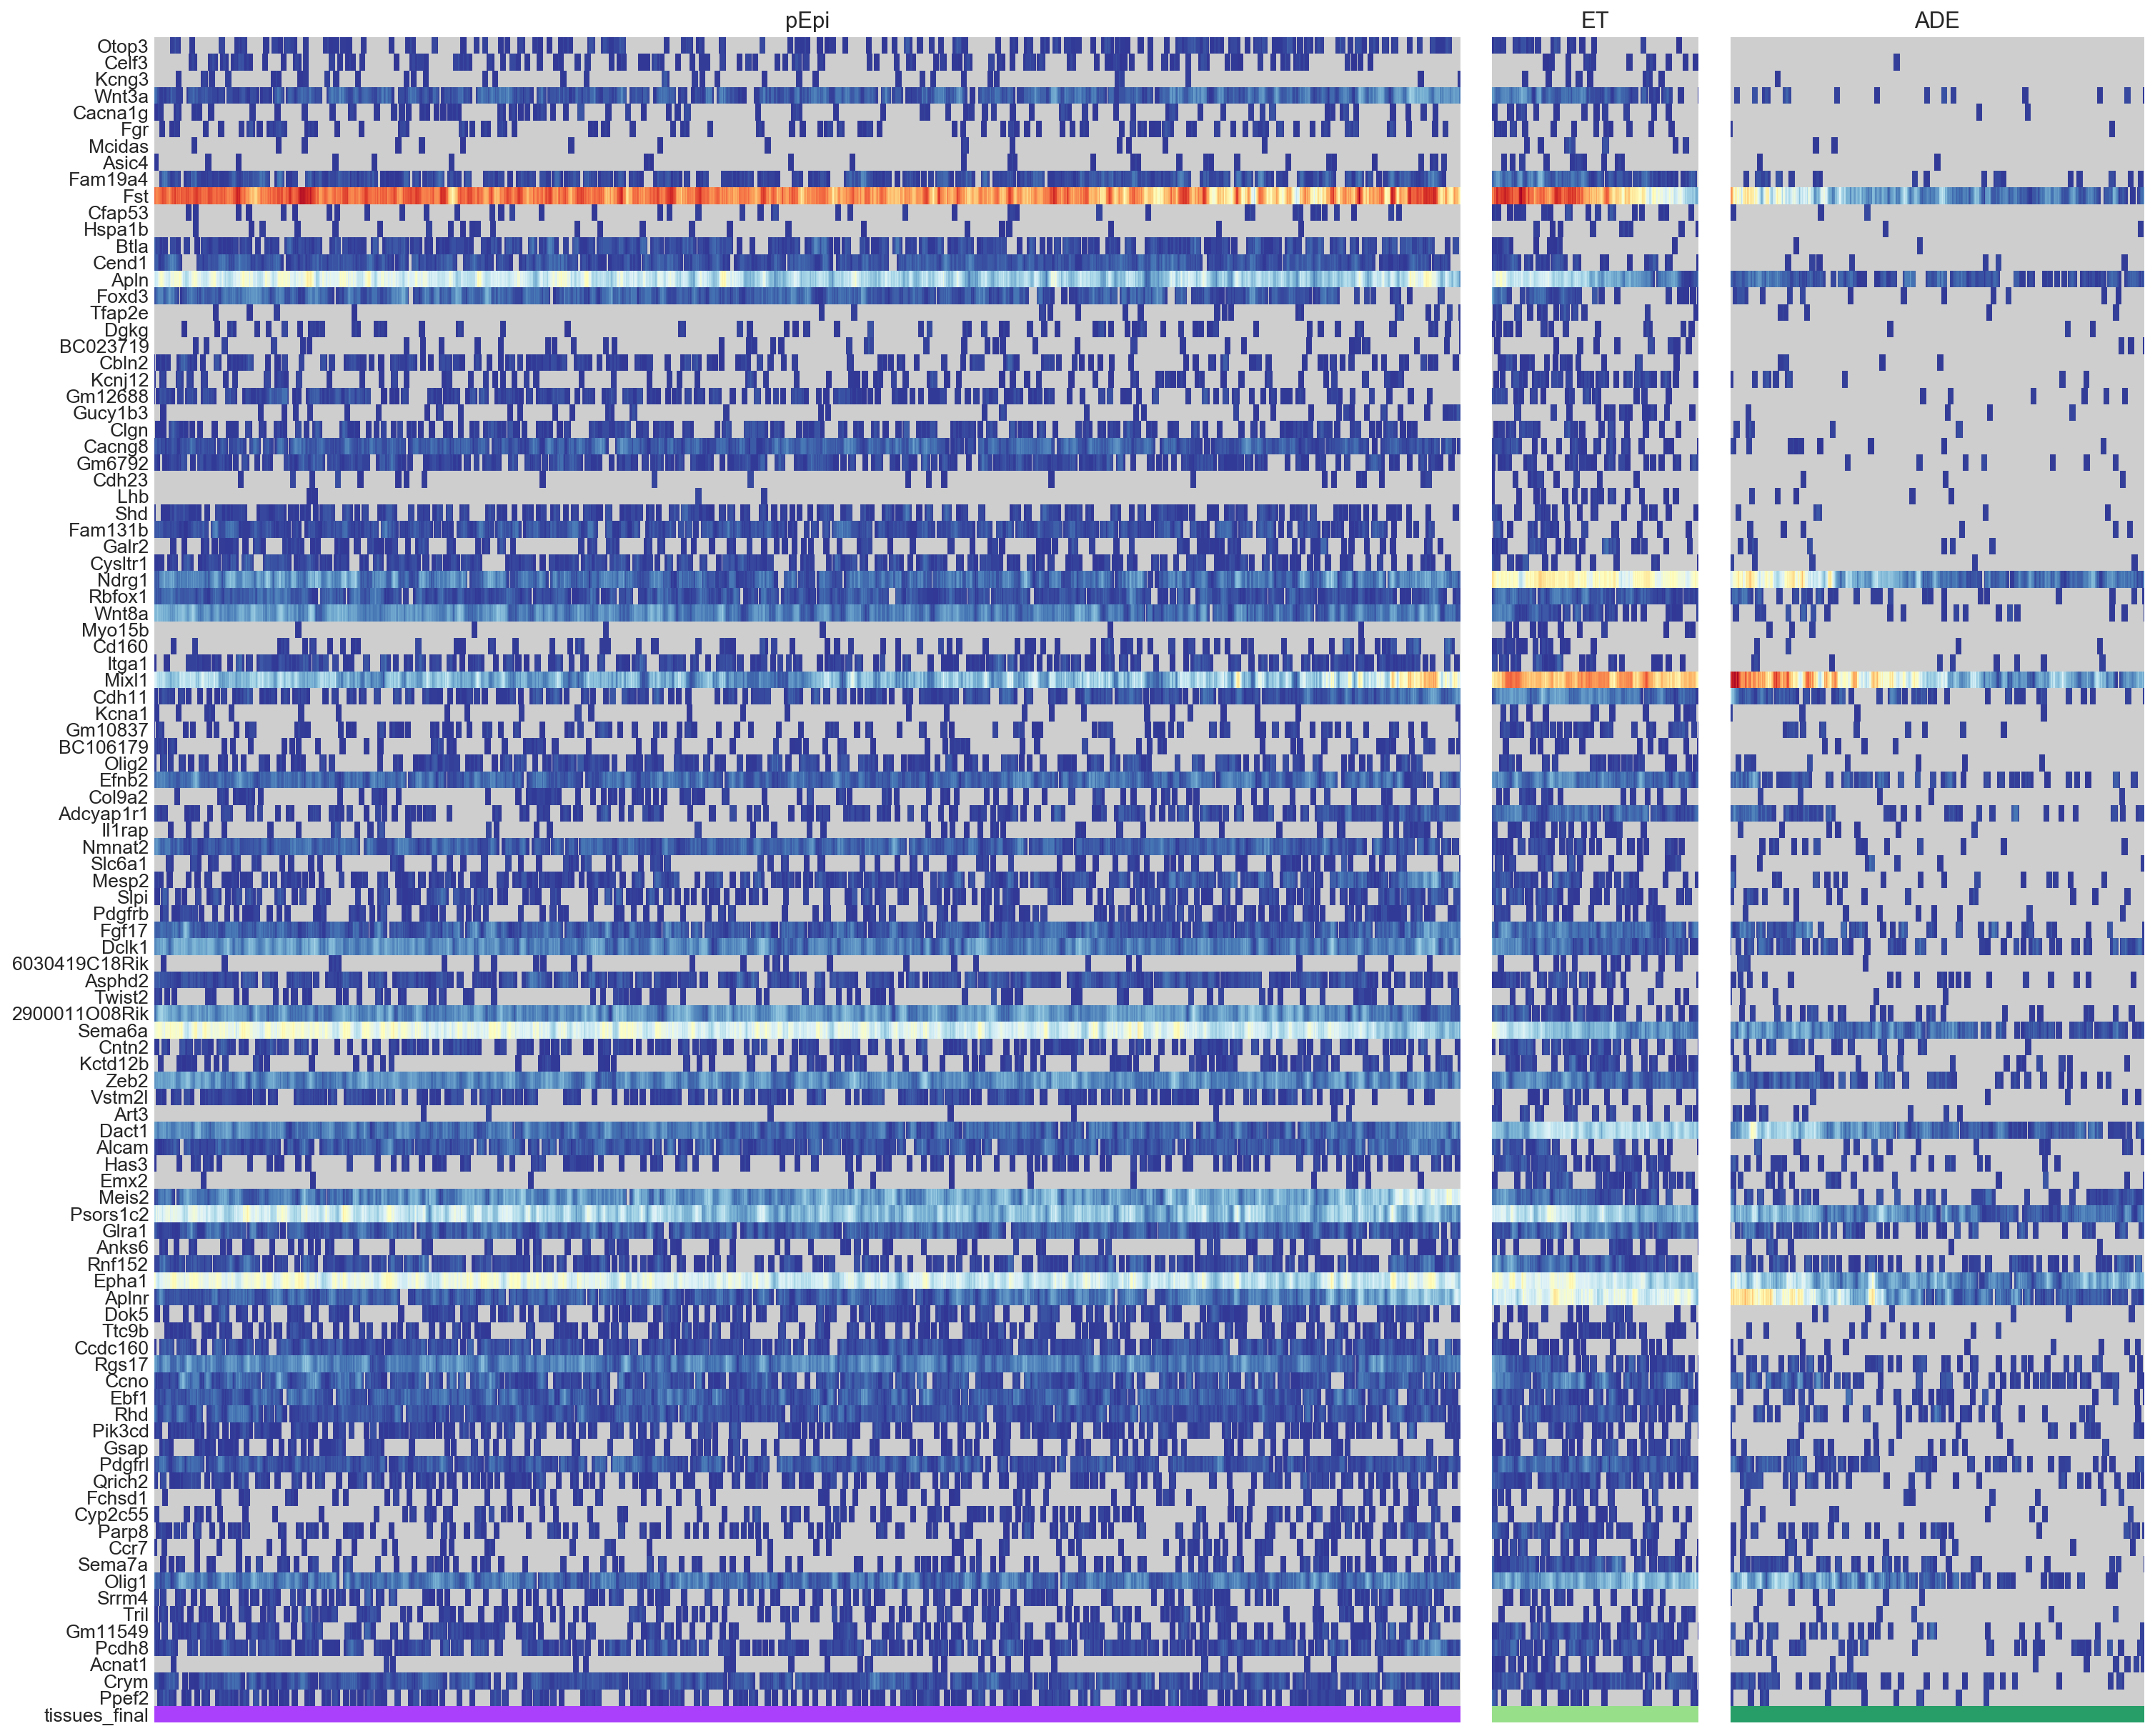

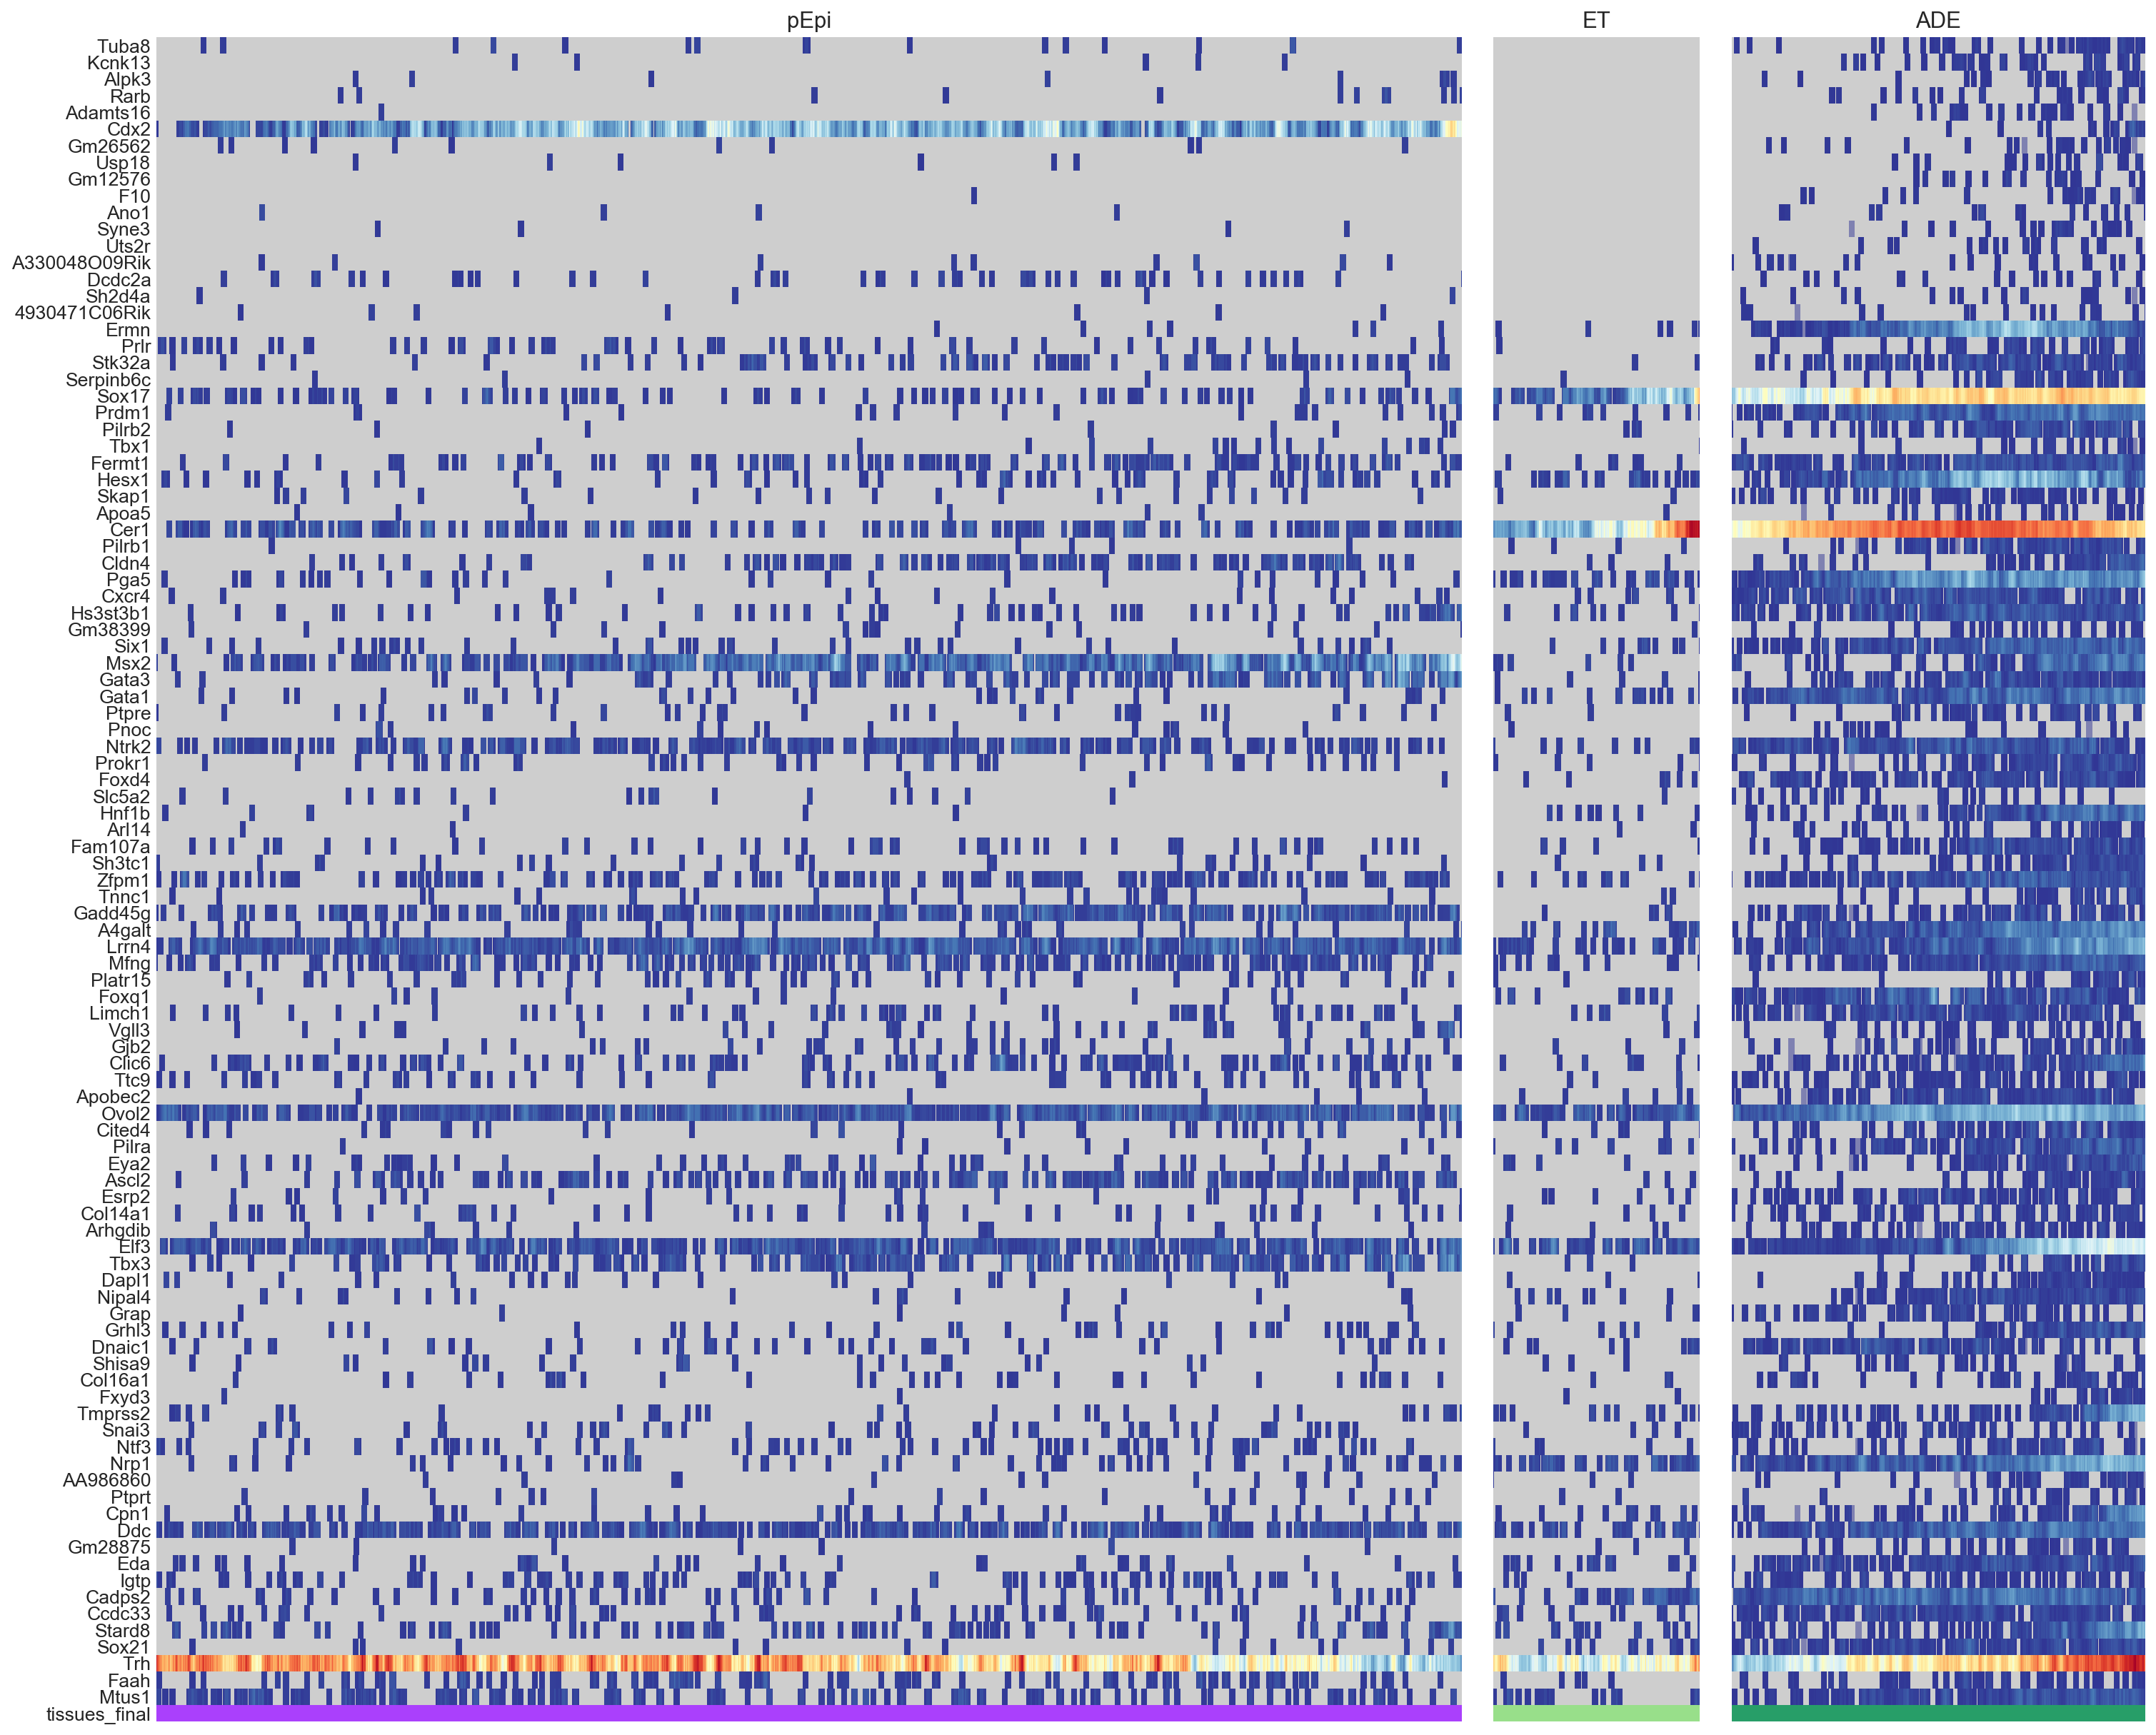

In [79]:

paths = [
        ('pEpi',['posterior epiblast']),
        ('TP',['transitory progenitors']),
        ('ADE',['anterior definitive endoderm']),
        #('AM', ['axial mesoderm']),
    ]

path_ratios= pd.value_counts(adata.obs['tissues_final']).values
path_cat = pd.value_counts(adata.obs['tissues_final']).index
tmp=np.zeros(len(paths))
for ipath, (descr, path) in enumerate(paths):
    #print(path[1])
    idx = np.flatnonzero(np.in1d(path_cat, path))
    #print(idx)
    tmp[ipath] = path_ratios[idx]
    
tmp = tmp.astype('int')
path_ratios = tmp / tmp.sum() *len(path_ratios)

_, axs = pl.subplots(ncols=len(tmp), figsize=(20, 20), 
                     gridspec_kw={'wspace': 0.05, 'left': 0.11,'width_ratios':path_ratios})
pl.subplots_adjust(left=0.05, right=0.98, top=0.88)
for ipath, (descr, path) in enumerate(paths):
    sc.pl.paga_path(adata, left_margin=0.3, ytick_fontsize=12, color_map=mymap,
                   nodes=path, ax=axs[ipath],
                   keys=np.concatenate([low_ade_genes]),
                   annotations=[],
                   color_maps_annotations={'FVF' : 'Greys'},
                   show_yticks=True if ipath==0 else False,
                   show_node_names = False,
                   show_colorbar=True if ipath==3 else False,                        
                   n_avg=10,
                   normalize_to_zero_one = False,
                   title='{}'.format(descr),
                   show=False)
pl.savefig('./figures/' + today + '_heatmap_TP_ade_low.pdf', dpi=150)
pl.show()

_, axs = pl.subplots(ncols=len(tmp), figsize=(20, 20), 
                     gridspec_kw={'wspace': 0.05, 'left': 0.11,'width_ratios':path_ratios})
pl.subplots_adjust(left=0.05, right=0.98, top=0.88)
for ipath, (descr, path) in enumerate(paths):
    sc.pl.paga_path(adata, left_margin=0.3, ytick_fontsize=12, color_map=mymap,
                   nodes=path, ax=axs[ipath],
                   keys=np.concatenate([high_ade_genes]),
                   annotations=[],
                   color_maps_annotations={'FVF' : 'Greys'},
                   show_yticks=True if ipath==0 else False,
                   show_node_names = False,
                   show_colorbar=True if ipath==3 else False,                        
                   n_avg=10,
                   normalize_to_zero_one = False,
                   title='{}'.format(descr),
                   show=False)
pl.savefig('./figures/' + today + '_heatmap_TP_ade_high.pdf', dpi=150)
pl.show()

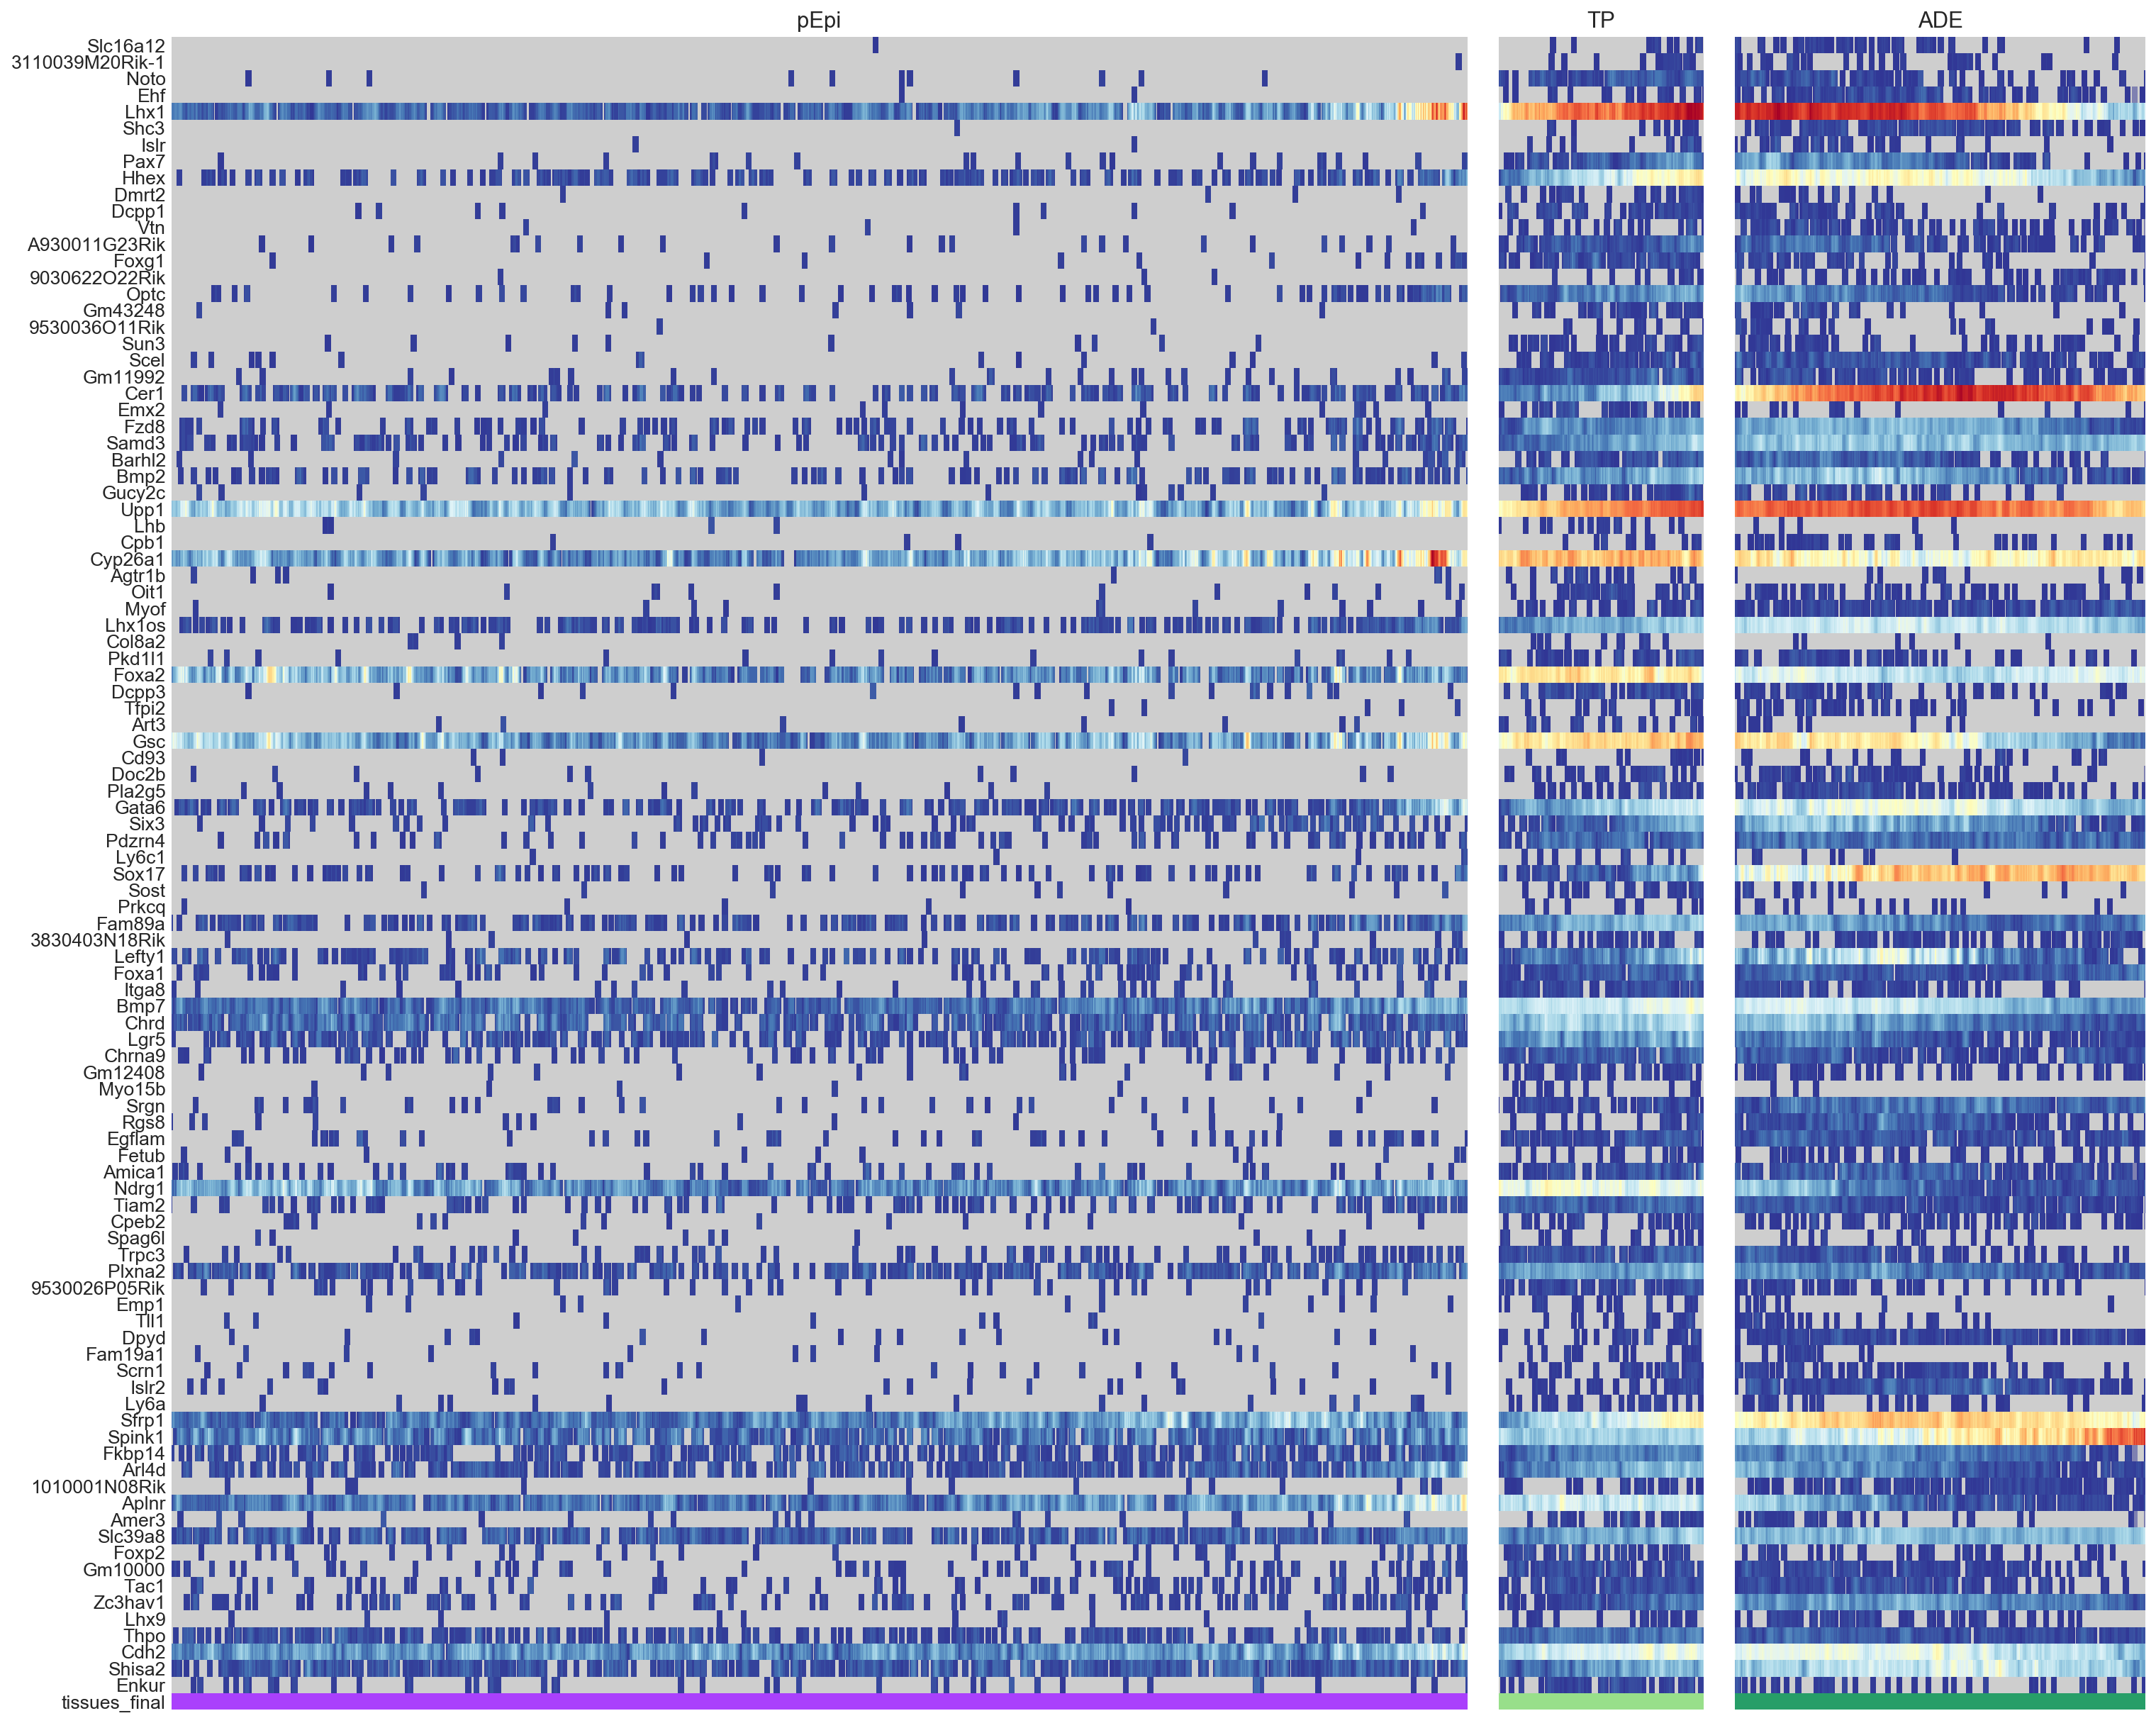

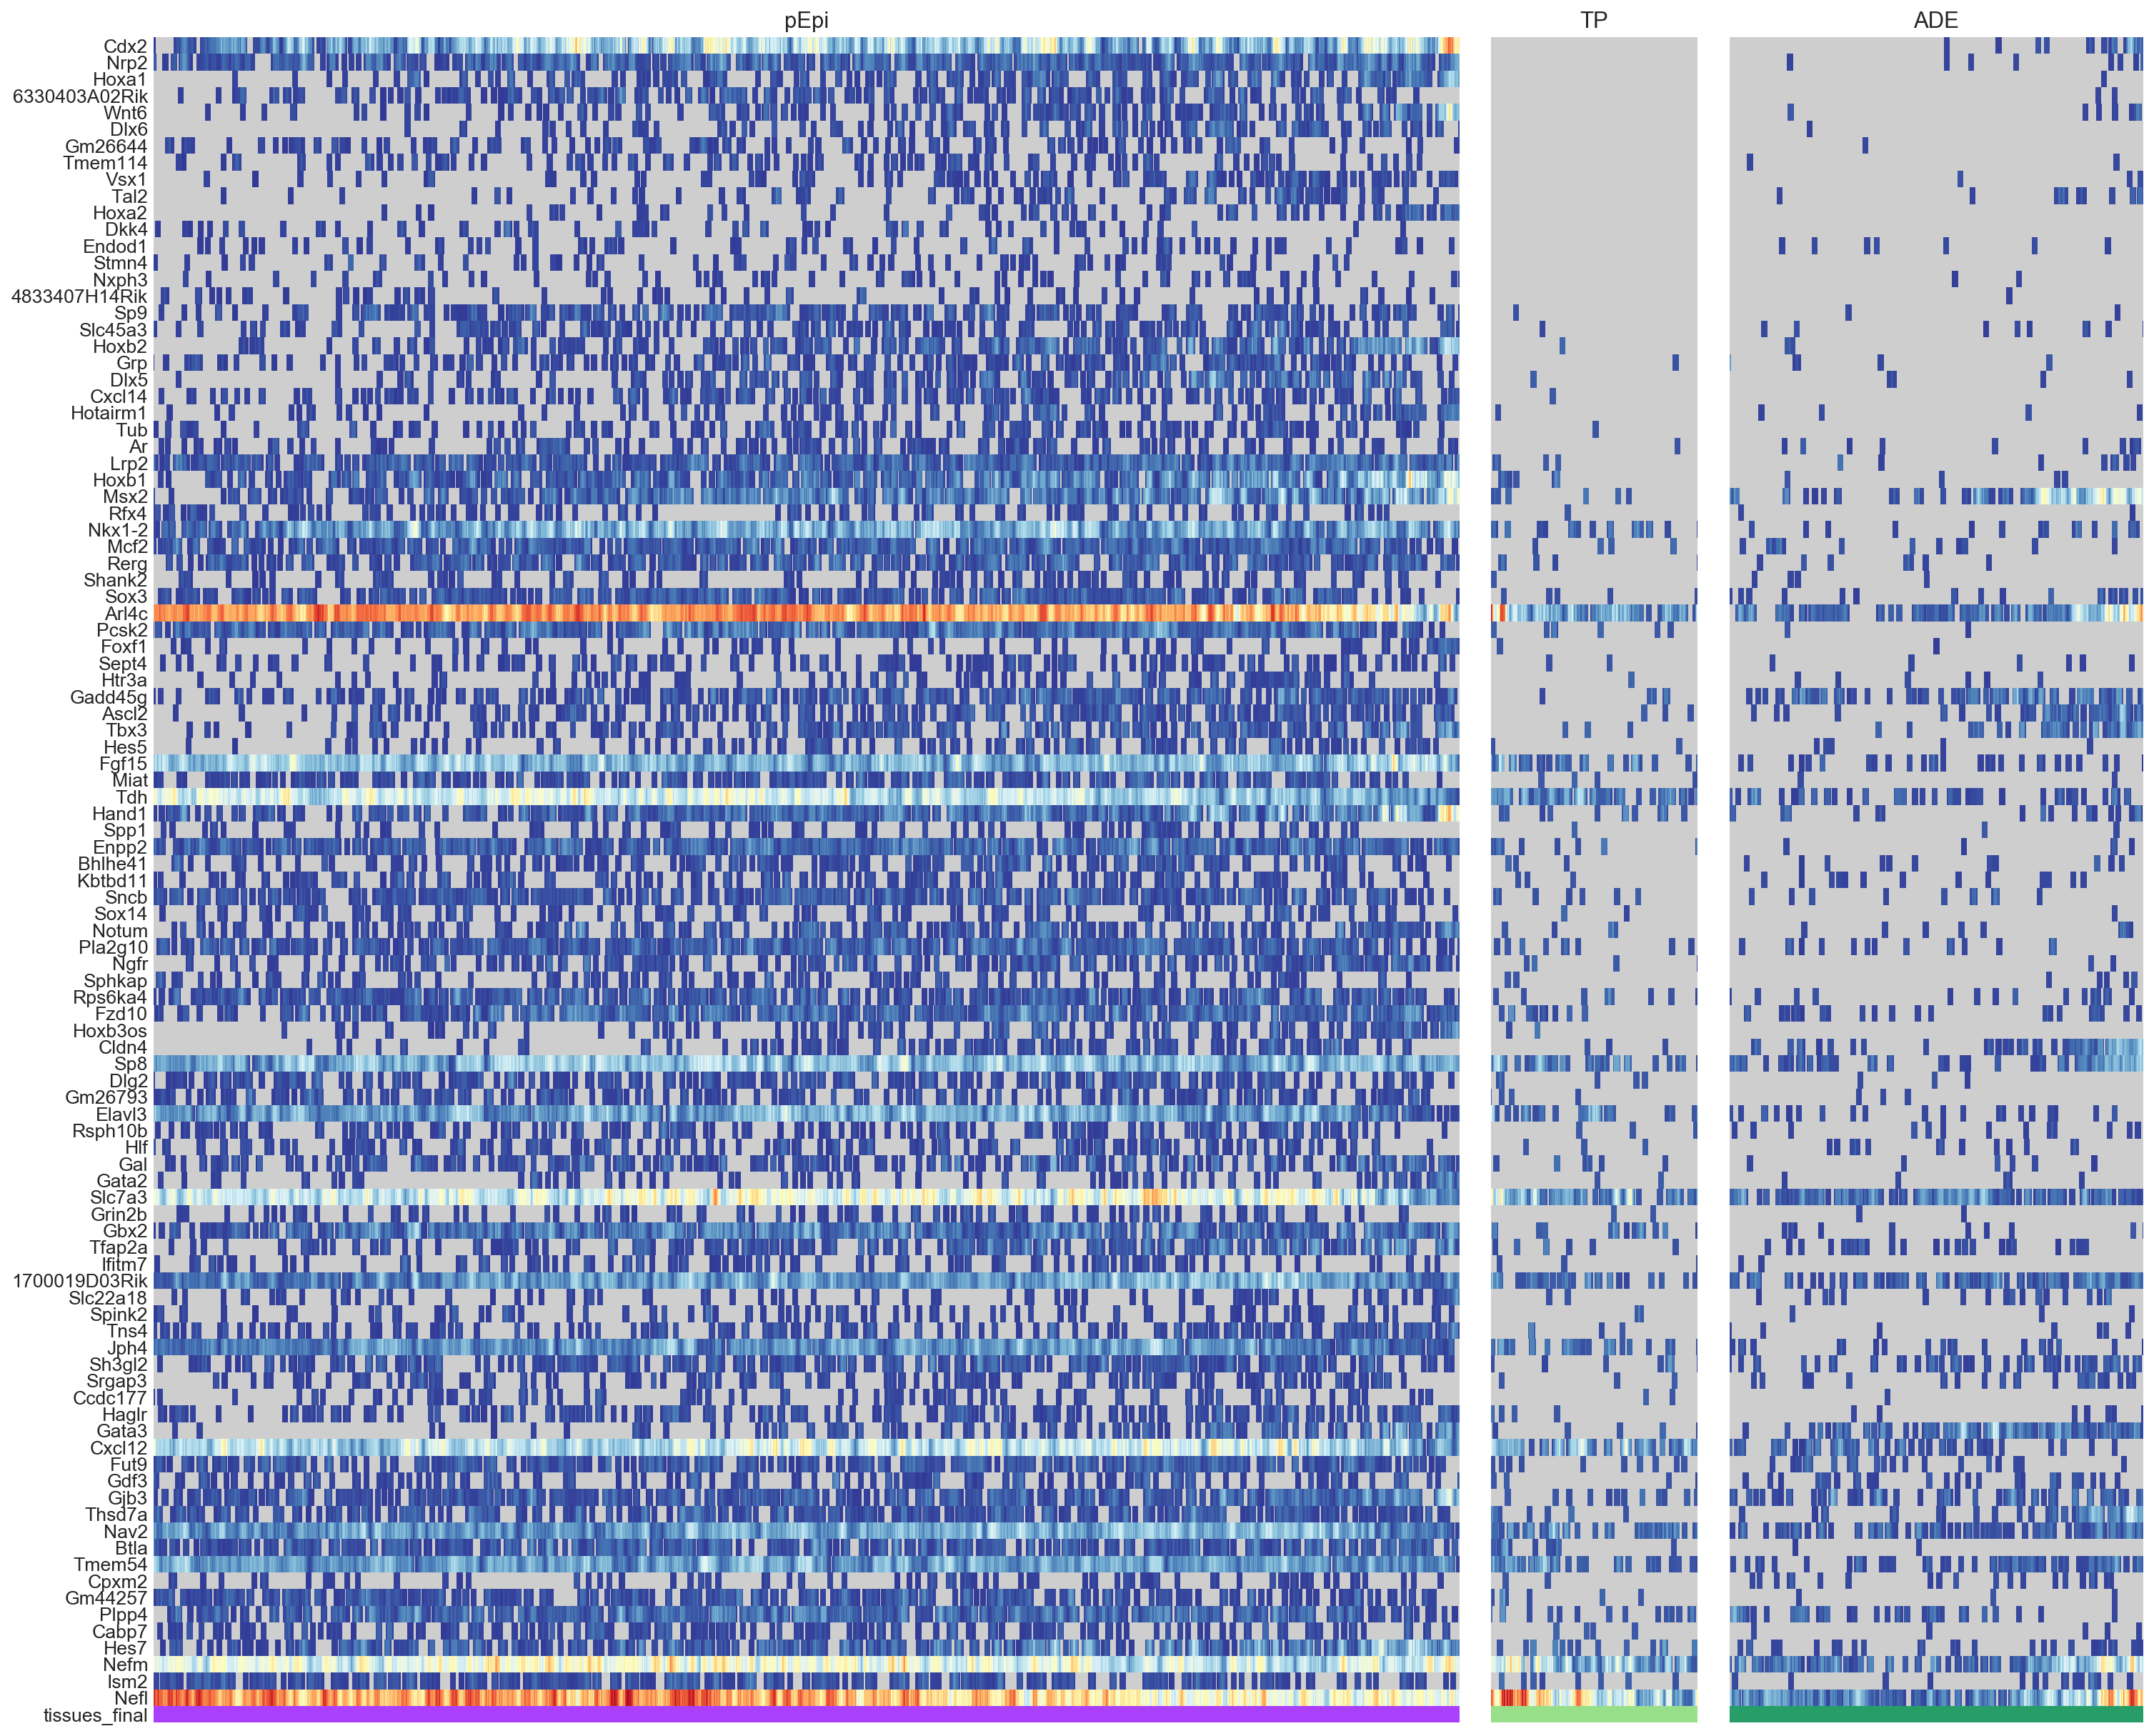

In [80]:

paths = [
        ('pEpi',['posterior epiblast']),
        ('TP',['transitory progenitors']),
        ('ADE',['anterior definitive endoderm']),
        #('AM', ['axial mesoderm']),
    ]

path_ratios= pd.value_counts(adata.obs['tissues_final']).values
path_cat = pd.value_counts(adata.obs['tissues_final']).index
tmp=np.zeros(len(paths))
for ipath, (descr, path) in enumerate(paths):
    #print(path[1])
    idx = np.flatnonzero(np.in1d(path_cat, path))
    #print(idx)
    tmp[ipath] = path_ratios[idx]
    
tmp = tmp.astype('int')
path_ratios = tmp / tmp.sum() *len(path_ratios)

_, axs = pl.subplots(ncols=len(tmp), figsize=(20, 20), 
                     gridspec_kw={'wspace': 0.05, 'left': 0.11,'width_ratios':path_ratios})
pl.subplots_adjust(left=0.05, right=0.98, top=0.88)
for ipath, (descr, path) in enumerate(paths):
    sc.pl.paga_path(adata, left_margin=0.3, ytick_fontsize=12, color_map=mymap,
                   nodes=path, ax=axs[ipath],
                   keys=np.concatenate([low_epi_genes]),
                   annotations=[],
                   color_maps_annotations={'FVF' : 'Greys'},
                   show_yticks=True if ipath==0 else False,
                   show_node_names = False,
                   show_colorbar=True if ipath==3 else False,                        
                   n_avg=10,
                   normalize_to_zero_one = False,
                   title='{}'.format(descr),
                   show=False)
pl.savefig('./figures/' + today + '_heatmap_TP_postepi_low.pdf', dpi=150)
pl.show()

_, axs = pl.subplots(ncols=len(tmp), figsize=(20, 20), 
                     gridspec_kw={'wspace': 0.05, 'left': 0.11,'width_ratios':path_ratios})
pl.subplots_adjust(left=0.05, right=0.98, top=0.88)
for ipath, (descr, path) in enumerate(paths):
    sc.pl.paga_path(adata, left_margin=0.3, ytick_fontsize=12, color_map=mymap,
                   nodes=path, ax=axs[ipath],
                   keys=np.concatenate([high_epi_genes]),
                   annotations=[],
                   color_maps_annotations={'FVF' : 'Greys'},
                   show_yticks=True if ipath==0 else False,
                   show_node_names = False,
                   show_colorbar=True if ipath==3 else False,                        
                   n_avg=10,
                   normalize_to_zero_one = False,
                   title='{}'.format(descr),
                   show=False)
pl.savefig('./figures/' + today + '_heatmap_TP_postepi_high.pdf', dpi=150)
pl.show()

In [81]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['tissue_Foxa2']=='Foxa2+ posterior epiblast')[0]
sc.tl.dpt(adata)
sc.tl.paga(adata, groups='tissue_Foxa2')

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


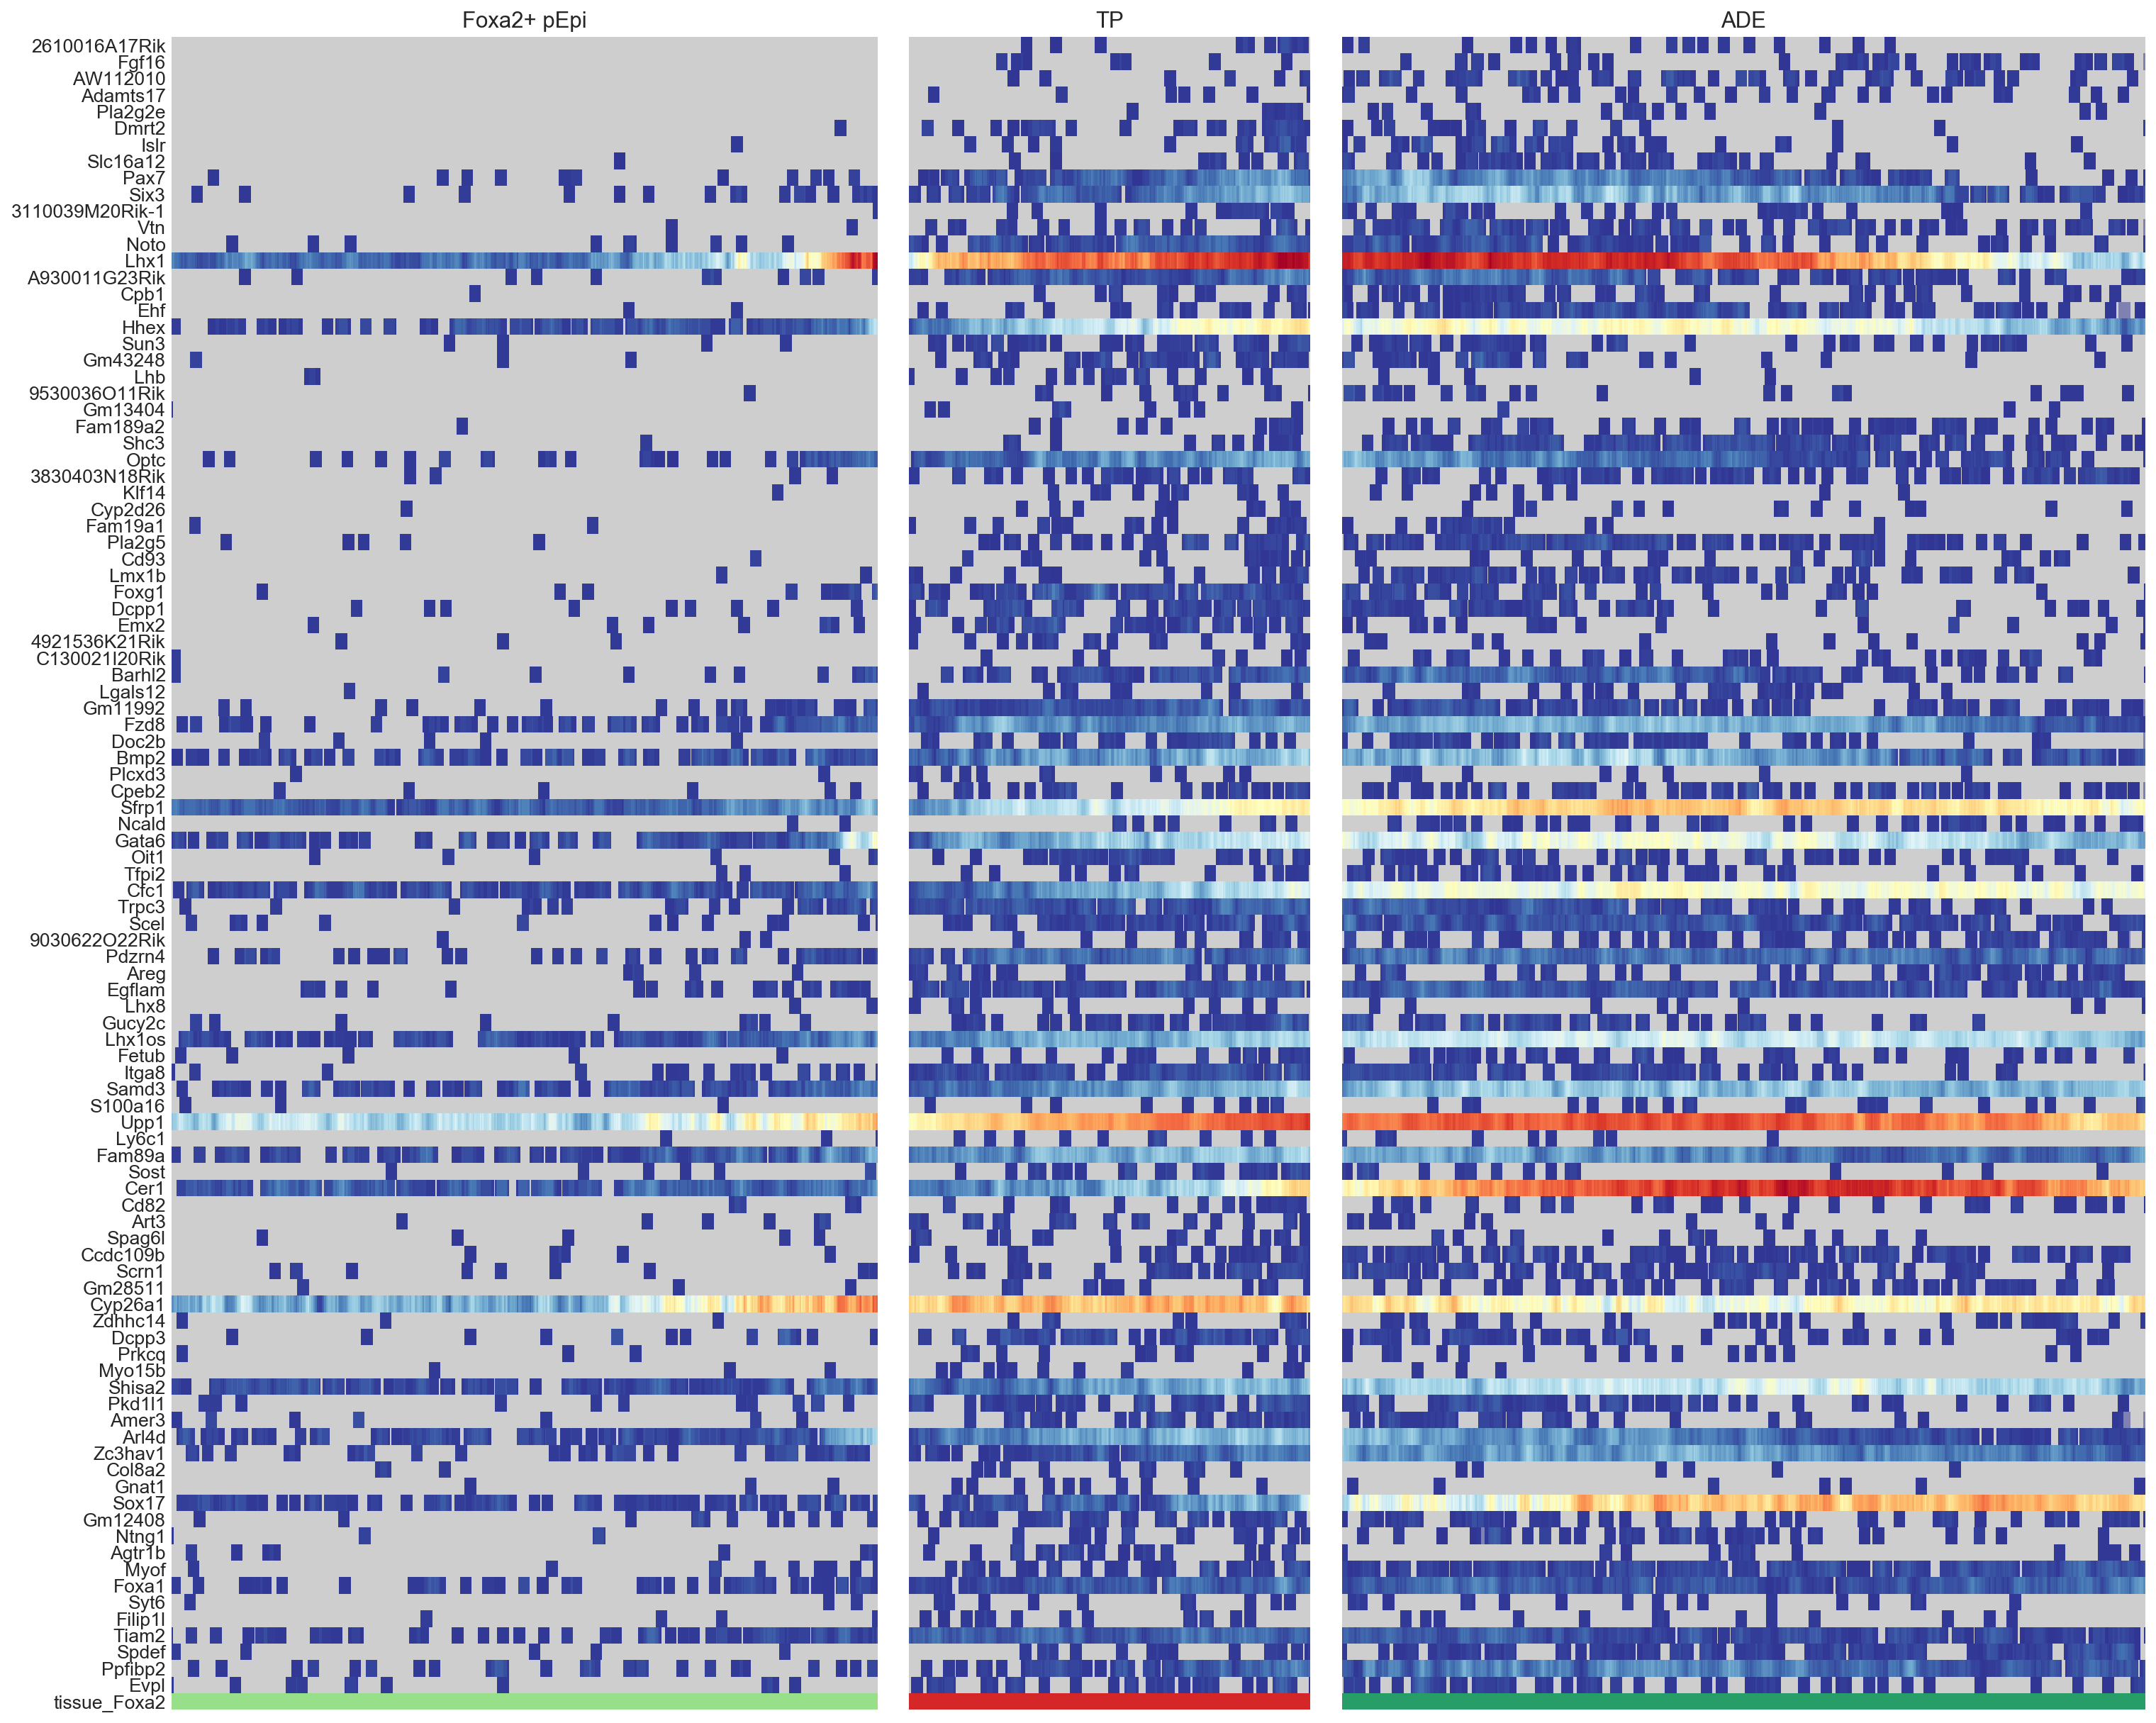

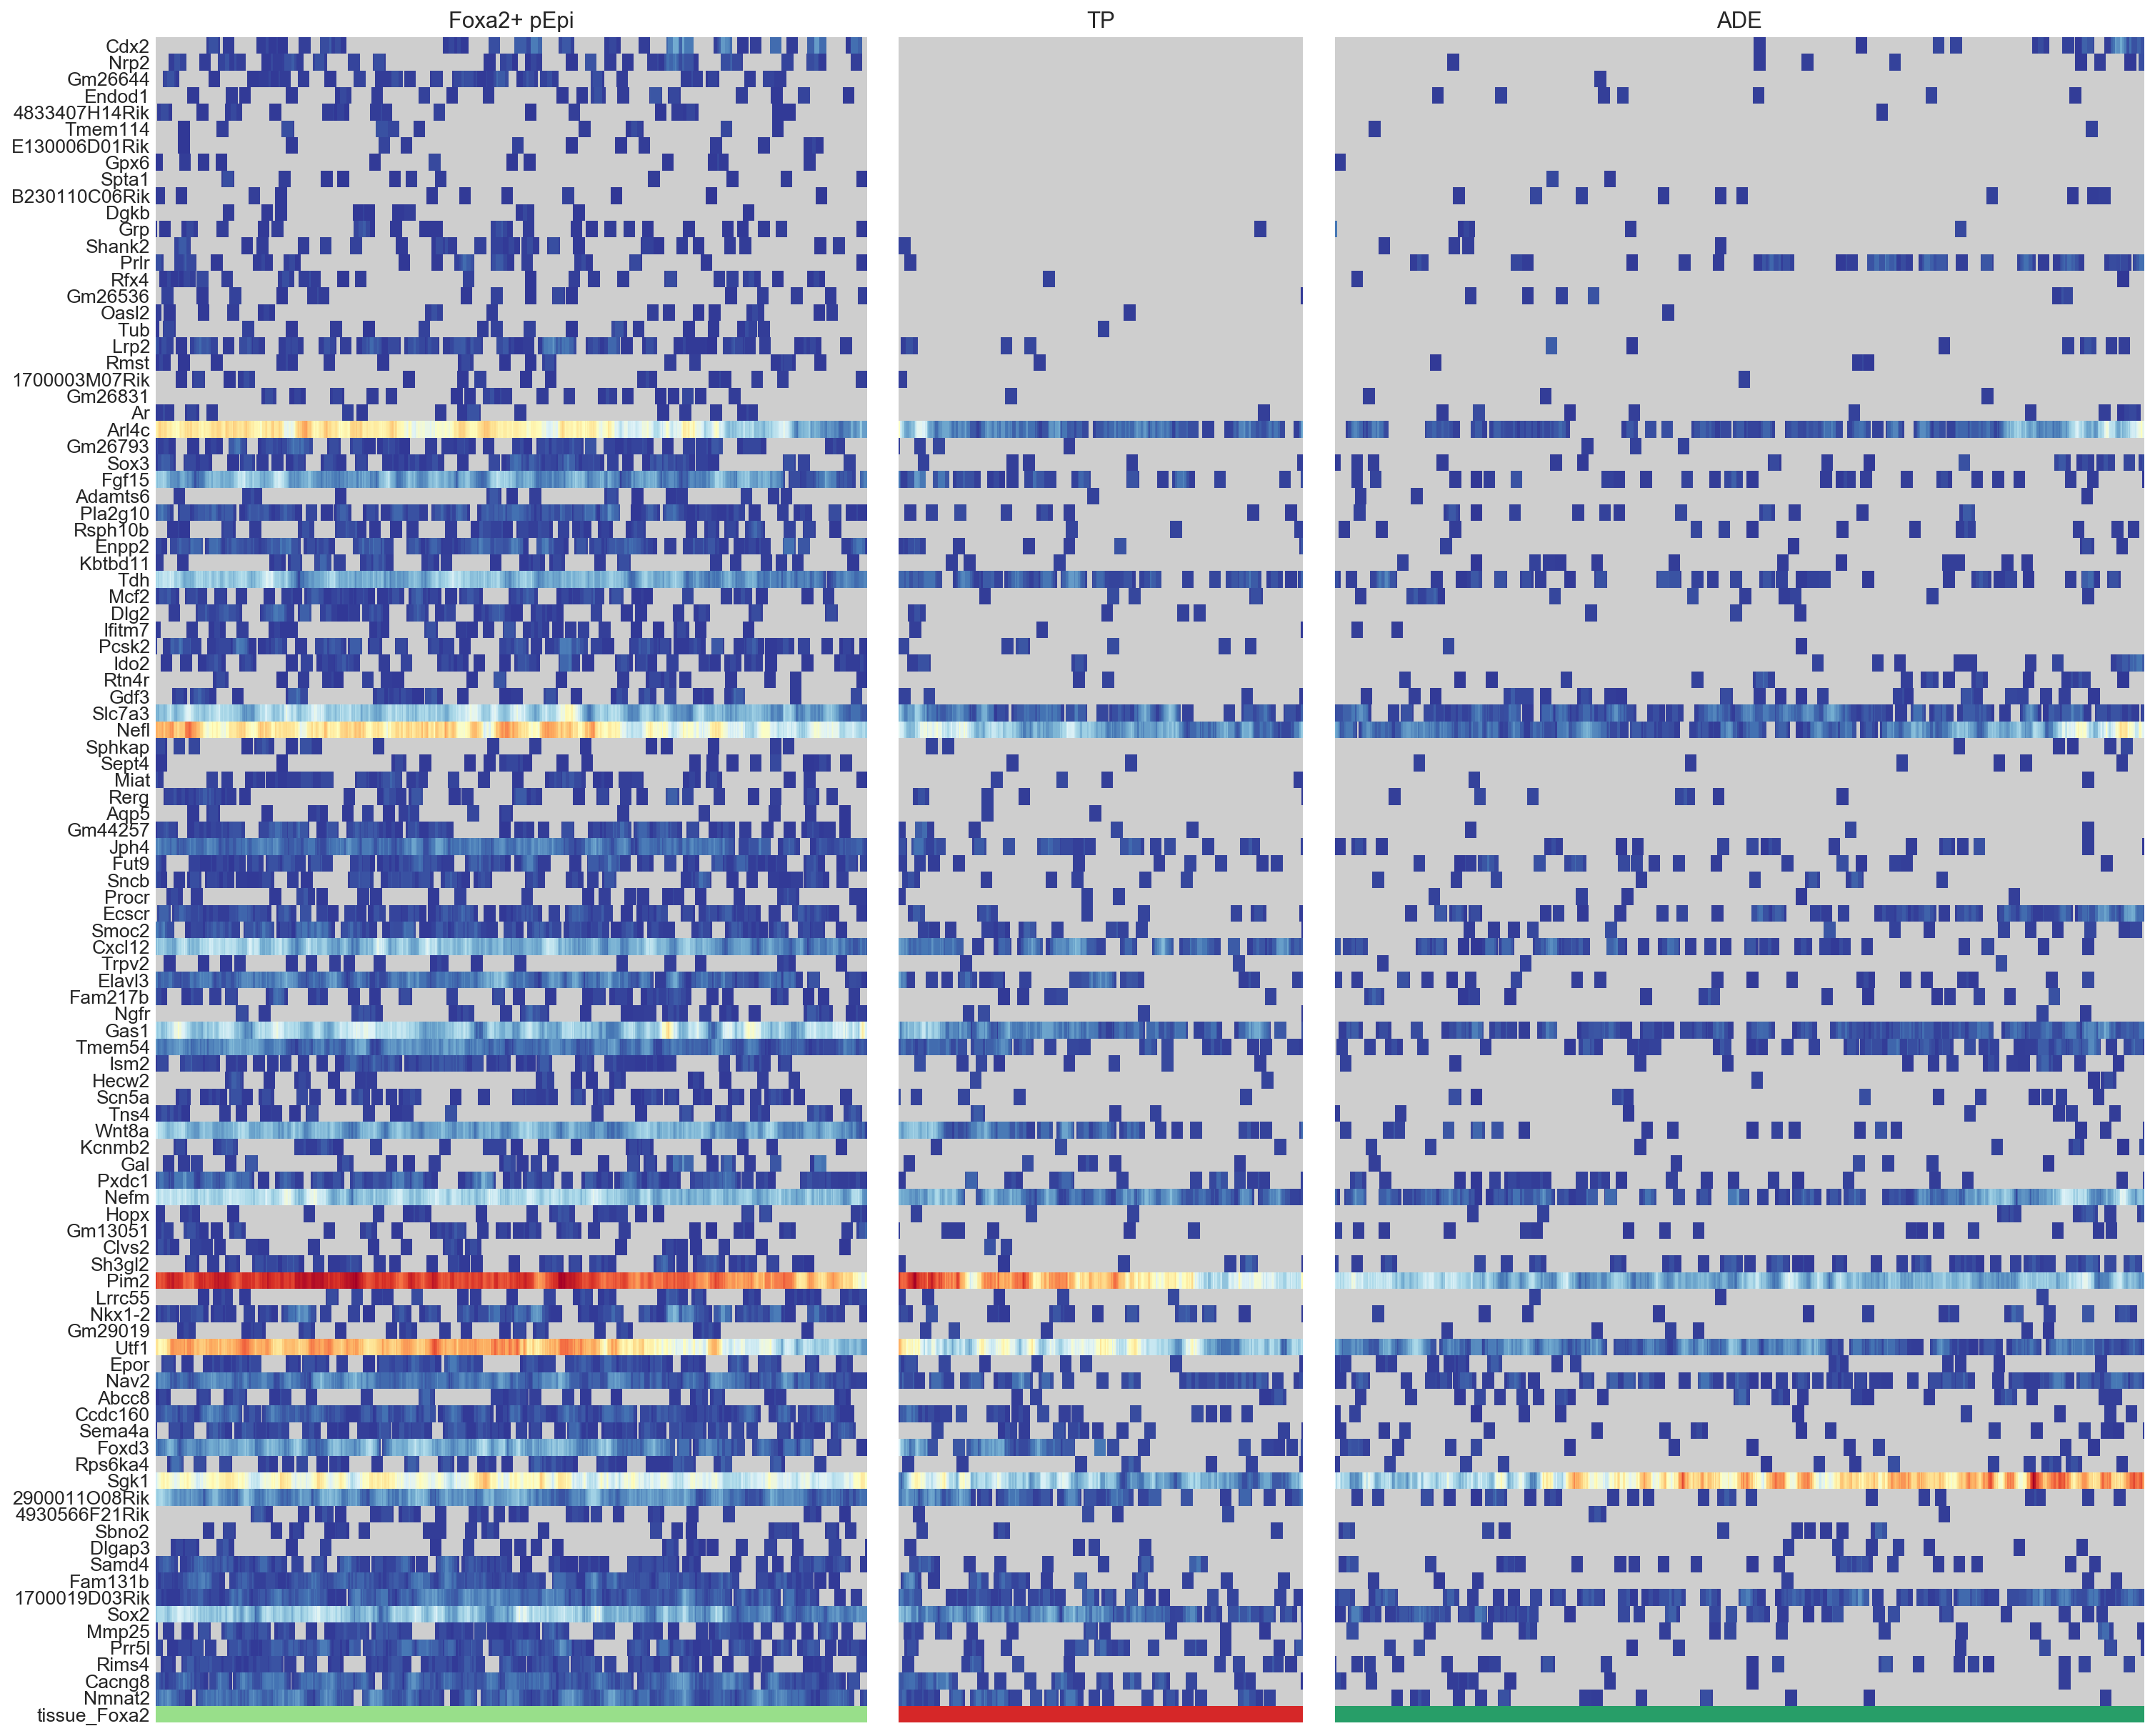

In [82]:

paths = [
        ('Foxa2+ pEpi',['Foxa2+ posterior epiblast']),
        ('TP',['transitory progenitors']),
        ('ADE',['anterior definitive endoderm']),
        #('AM', ['axial mesoderm']),
    ]

path_ratios= pd.value_counts(adata.obs['tissue_Foxa2']).values
path_cat = pd.value_counts(adata.obs['tissue_Foxa2']).index
tmp=np.zeros(len(paths))
for ipath, (descr, path) in enumerate(paths):
    #print(path[1])
    idx = np.flatnonzero(np.in1d(path_cat, path))
    #print(idx)
    tmp[ipath] = path_ratios[idx]
    
tmp = tmp.astype('int')
path_ratios = tmp / tmp.sum() *len(path_ratios)

_, axs = pl.subplots(ncols=len(tmp), figsize=(20, 20), 
                     gridspec_kw={'wspace': 0.05, 'left': 0.11,'width_ratios':path_ratios})
pl.subplots_adjust(left=0.05, right=0.98, top=0.88)
for ipath, (descr, path) in enumerate(paths):
    sc.pl.paga_path(adata, left_margin=0.3, ytick_fontsize=12, color_map=mymap,
                   nodes=path, ax=axs[ipath],
                   keys=np.concatenate([low_Foxa2epi_genes]),
                   annotations=[],
                   color_maps_annotations={'FVF' : 'Greys'},
                   show_yticks=True if ipath==0 else False,
                   show_node_names = False,
                   show_colorbar=True if ipath==3 else False,                        
                   n_avg=10,
                   normalize_to_zero_one = False,
                   title='{}'.format(descr),
                   show=False)
pl.savefig('./figures/' + today + '_heatmap_TP_Foxa2_postepi_low.pdf', dpi=150)
pl.show()

_, axs = pl.subplots(ncols=len(tmp), figsize=(20, 20), 
                     gridspec_kw={'wspace': 0.05, 'left': 0.11,'width_ratios':path_ratios})
pl.subplots_adjust(left=0.05, right=0.98, top=0.88)
for ipath, (descr, path) in enumerate(paths):
    sc.pl.paga_path(adata, left_margin=0.3, ytick_fontsize=12, color_map=mymap,
                   nodes=path, ax=axs[ipath],
                   keys=np.concatenate([high_Foxa2epi_genes]),
                   annotations=[],
                   color_maps_annotations={'FVF' : 'Greys'},
                   show_yticks=True if ipath==0 else False,
                   show_node_names = False,
                   show_colorbar=True if ipath==3 else False,                        
                   n_avg=10,
                   normalize_to_zero_one = False,
                   title='{}'.format(descr),
                   show=False)
pl.savefig('./figures/' + today + '_heatmap_TP_Foxa2_postepi_high.pdf', dpi=150)
pl.show()

## Test Foxa2+ vs Foxa2- posterior epiblast

In [36]:
adata.obs['tissue_Foxa2'] = adata.obs['tissues_final'].cat.add_categories(['Foxa2+ posterior epiblast', 
                                                                           'Foxa2- posterior epiblast'])
adata.obs['tissue_Foxa2'][np.logical_and(adata.obs['tissues_final']=='posterior epiblast',
                                         adata.obs['Foxa2_levels'] == 'Foxa2 neg'
                                        )] = 'Foxa2- posterior epiblast'

adata.obs['tissue_Foxa2'][np.logical_and(adata.obs['tissues_final']=='posterior epiblast',
                                         adata.obs['Foxa2_levels'] != 'Foxa2 neg'
                                        )] = 'Foxa2+ posterior epiblast'

adata.obs['tissue_Foxa2'] = adata.obs['tissue_Foxa2'].cat.remove_unused_categories()

Reorder categories.

In [37]:
adata.obs['tissue_Foxa2'] = adata.obs['tissue_Foxa2'].cat.reorder_categories([
        'extraembryonic endoderm', 'extraembryonic ectoderm',
       'anterior definitive endoderm', 'transitory progenitors',
       'axial mesendoderm', 'Foxa2+ posterior epiblast',
       'Foxa2- posterior epiblast', 'epiblast', 'PGC', 'paraxial mesoderm',
       'intermediate mesoderm', 'lateral plate mesoderm',
       'nascent endothelium'
    ])

In [42]:
adata.uns['tissue_Foxa2_colors'] = ['#1f77b4', '#ff7f0e', '#279e68', '#98df8a', '#17becf', 
                                    '#0ccf0c', #Foxa2+ posterior epiblast
                                    '#98ddca', #Foxa2- posterior epiblast
       '#ffbb78', '#8c564b', '#e377c2', '#ff9896', '#d12e77', '#830229']

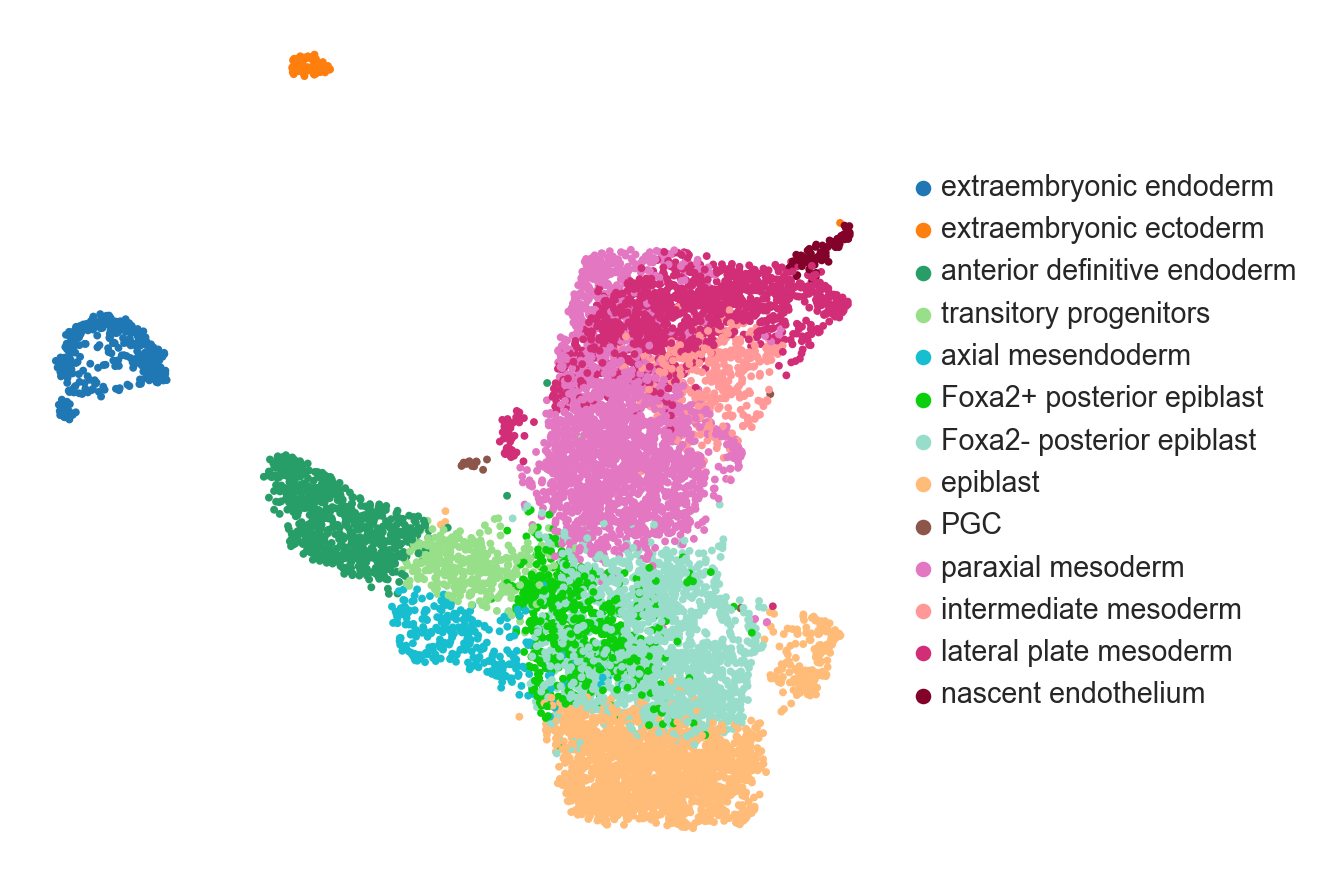

In [43]:
rcParams['figure.figsize'] = (7,7)
sc.pl.umap(adata, color='tissue_Foxa2', size=50, frameon=False, title='', save = today + 'Foxa2_pEpi.pdf')

In [44]:
sc.tl.rank_genes_groups(adata, 'tissue_Foxa2', 
                        groups=['Foxa2+ posterior epiblast', 'Foxa2- posterior epiblast'],
                        reference='Foxa2+ posterior epiblast',
                        rankby_abs=True, key_added='Foxa2pos_vs_Foxa2neg_pEpi', n_genes = adata.raw.n_vars)

ranking genes
    finished: added to `.uns['Foxa2pos_vs_Foxa2neg_pEpi']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [45]:
dict_genes = adata.uns["Foxa2pos_vs_Foxa2neg_pEpi"].copy()

In [46]:
df = {}
for idx, elem in enumerate(list(dict_genes["names"].dtype.names)):
    print(idx, elem)
    df[elem+"_gene"] = []
    df[elem+"_logfoldchange"] = []
    df[elem+"_pval_adj"] = []
    for j in range(0, len(adata.var)):
        df[elem+"_gene"].append(dict_genes["names"][j][idx])
        df[elem+"_logfoldchange"].append(dict_genes["logfoldchanges"][j][idx])
        df[elem+"_pval_adj"].append(dict_genes["pvals_adj"][j][idx])

dataframe3 = pd.DataFrame(df)        
for idx, elem in enumerate(list(dict_genes["names"].dtype.names)):
    adata.raw.var[elem+"_mean"] = np.mean(adata.raw[adata.obs["tissue_Foxa2"] == elem,:].X, axis=0).A1
    adata.raw.var[elem+"_n_cells"] = np.sum(adata.raw[adata.obs["tissue_Foxa2"] == elem,:].X > 0, axis=0).A1
    dataframe3.index = dataframe3[elem+"_gene"]
    adata.raw.var[elem+"_log2FC"] = dataframe3[elem+"_logfoldchange"]
    adata.raw.var[elem+"_pvals_adj"] = dataframe3[elem+"_pval_adj"]

0 Foxa2- posterior epiblast


In [47]:
dataframe3.head(10)

Foxa2- posterior epiblast_gene  \
Foxa2- posterior epiblast_gene                                  
Foxa2                                                   Foxa2   
Gsc                                                       Gsc   
Fgf5                                                     Fgf5   
Car2                                                     Car2   
Upp1                                                     Upp1   
Epha2                                                   Epha2   
Adamts9                                               Adamts9   
Tdgf1                                                   Tdgf1   
Phlda2                                                 Phlda2   
Rps28                                                   Rps28   

                                Foxa2- posterior epiblast_logfoldchange  \
Foxa2- posterior epiblast_gene                                            
Foxa2                                                        -31.791466   
Gsc                                                           -3.330467   
Fgf5                                                          -1.727327   
Car2                                                          -1.333664   
Upp1                                                          -2.222816   
Epha2                                                         -1.917426   
Adamts9                                                       -2.459091   
Tdgf1                                                         -1.646315   
Phlda2                                                         2.149018   
Rps28                                                         -0.396677   

                                Foxa2- posterior epiblast_pval_adj  
Foxa2- posterior epiblast_gene                                      
Foxa2                                                 0.000000e+00  
Gsc                                                  6.204425e-282  
Fgf5                                                 1.378465e-248  
Car2                                                 2.040521e-226  
Upp1                                                 1.426934e-218  
Epha2                                                4.950344e-219  
Adamts9                                              1.229672e-209  
Tdgf1                                                6.847677e-185  
Phlda2                                               2.421213e-185  
Rps28                                                5.082901e-183

In [48]:
adata.raw.var

gene_ids  n_cells  highly_variable     means  \
index                                                                    
Xkr4            ENSMUSG00000051951       57            False  0.004872   
Sox17           ENSMUSG00000025902     1488             True  0.489130   
Mrpl15          ENSMUSG00000033845     9713            False  2.306435   
Lypla1          ENSMUSG00000025903     8279            False  1.060121   
Gm37988         ENSMUSG00000104217       26            False  0.001943   
...                            ...      ...              ...       ...   
Tmlhe           ENSMUSG00000079834       61            False  0.004199   
AC168977.1      ENSMUSG00000079808       29            False  0.003047   
PISD            ENSMUSG00000095041     6589             True  0.720177   
DHRSX           ENSMUSG00000063897     6656            False  0.679292   
CAAA01147332.1  ENSMUSG00000095742      197            False  0.014963   

                dispersions  dispersions_norm  highly_variable_nbatches  \
index                                                                     
Xkr4               0.690311         -0.269835                         1   
Sox17              1.541342         21.115414                         8   
Mrpl15             0.087948          0.040912                         0   
Lypla1             0.335781          0.583897                         2   
Gm37988            0.628470         -0.181854                         1   
...                     ...               ...                       ...   
Tmlhe              0.660676         -0.298788                         0   
AC168977.1         0.782815          1.019275                         2   
PISD               0.483913          1.259717                         5   
DHRSX              0.429873         -0.583423                         0   
CAAA01147332.1     0.712429         -0.330781                         1   

                highly_variable_intersection  \
index                                          
Xkr4                                   False   
Sox17                                   True   
Mrpl15                                 False   
Lypla1                                 False   
Gm37988                                False   
...                                      ...   
Tmlhe                                  False   
AC168977.1                             False   
PISD                                   False   
DHRSX                                  False   
CAAA01147332.1                         False   

                anterior definitive endoderm_mean  \
index                                               
Xkr4                                     0.006192   
Sox17                                    2.694965   
Mrpl15                                   2.374410   
Lypla1                                   1.281326   
Gm37988                                  0.002784   
...                                           ...   
Tmlhe                                    0.004003   
AC168977.1                               0.000670   
PISD                                     0.789915   
DHRSX                                    0.755725   
CAAA01147332.1                           0.016352   

                anterior definitive endoderm_n_cells  ...  \
index                                                 ...   
Xkr4                                               9  ...   
Sox17                                            661  ...   
Mrpl15                                           698  ...   
Lypla1                                           656  ...   
Gm37988                                            3  ...   
...                                              ...  ...   
Tmlhe                                              5  ...   
AC168977.1                                         1  ...   
PISD                                             542  ...   
DHRSX                                            537  ...   
CAAA01147332.1                          

Filter the top 100 up/down regulated genes in the Foxa2+ vs Foxa2- posterior epiblast comparison.

In [49]:
low_Foxa2neg_epi_genes = dataframe3[dataframe3['Foxa2- posterior epiblast_logfoldchange']<0].sort_values(
    'Foxa2- posterior epiblast_logfoldchange', 
    ascending=True).index[:100]
high_Foxa2neg_epi_genes = dataframe3[dataframe3['Foxa2- posterior epiblast_logfoldchange']>0].sort_values(
    'Foxa2- posterior epiblast_logfoldchange', 
    ascending=False).index[:100]

In [50]:
high_Foxa2neg_epi_genes

Index(['Tlx2', 'Gsx1', 'Pax3', 'Cdh6', 'Dlx6os1', 'Dlk2', 'Lingo3', 'Ubd',
       'Tac2', 'Cyp1a1', 'Slc32a1', 'Adamts17', 'Pitx3', 'Dlx5', 'Dlx6',
       'Dlx3', 'Gata3', 'Vsx1', 'Tal2', 'Hoxb3os', 'Lrrc7', 'Dkk4', 'Cdx2',
       'Hmx1', 'Elf5', 'Sgpp2', 'Neurog1', 'Sp9', 'Wnt6', 'Bmp8b', 'Prss35',
       'Msx2', 'Shtn1', 'C430039J16Rik', 'Ptchd1', 'Ptchd4', 'Gdf10', 'Podn',
       'Stk32a', 'R3hdml', 'Hoxb2', 'Hoxa1', 'Bmper', 'Epha10', 'Tacstd2',
       'RP23-316J6.4', 'Ascl2', 'Gabra5', 'Tmprss12', 'Hoxb4', 'Hoxb1',
       'Hotairm1', 'Hand1', 'Gfra3', 'Prrx1', '6330403A02Rik', 'Sh2d5',
       'Gm3336', 'S100a16', 'Hoxa2', 'Cdx4', 'Coch', '2510009E07Rik', 'Lhfpl5',
       'Gata2', 'Hes7', 'Notum', 'Scara3', 'Ccdc177', 'Agmat', 'Cxcl14',
       'Tbx3', 'Alx1', 'Slc45a3', 'Dync1i1', 'Tfap2a', 'Pak6', 'Gbx2', 'Pdx1',
       'Plpp4', 'Gadd45g', 'Nkx1-2', 'Hes3', 'Hes5', 'Gucy1a3', 'Scn9a',
       'Hoxa3', 'Tmem178', 'Rhbdl3', 'Tbx20', 'Nrp2', 'Wscd1', 'Hoxd1', 'Nefh',
       'Fgfr3', '

# Characterise posterior epiblast with epiblast as reference

We aim to characterise the gene expression of the posterior epiblast with respect to epiblast.

In [91]:
adata.obs['tissues_final'].cat.categories

Index(['extraembryonic endoderm', 'extraembryonic ectoderm',
       'anterior definitive endoderm', 'transitory progenitors',
       'axial mesendoderm', 'posterior epiblast', 'epiblast', 'PGC',
       'paraxial mesoderm', 'intermediate mesoderm', 'lateral plate mesoderm',
       'nascent endothelium'],
      dtype='object')

In [93]:
sc.tl.rank_genes_groups(adata, 'tissues_final', 
                        groups=['epiblast', 'posterior epiblast'],
                        reference='epiblast',rankby_abs=True, key_added='epiblast_vs_postepi', 
                        n_genes = adata.raw.n_vars)

ranking genes
    finished: added to `.uns['epiblast_vs_postepi']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [94]:
dict_genes = adata.uns["epiblast_vs_postepi"].copy()

In [95]:
df = {}
for idx, elem in enumerate(list(dict_genes["names"].dtype.names)):
    print(idx, elem)
    df[elem+"_gene"] = []
    df[elem+"_logfoldchange"] = []
    df[elem+"_pval_adj"] = []
    for j in range(0, len(adata.var)):
        df[elem+"_gene"].append(dict_genes["names"][j][idx])
        df[elem+"_logfoldchange"].append(dict_genes["logfoldchanges"][j][idx])
        df[elem+"_pval_adj"].append(dict_genes["pvals_adj"][j][idx])

dataframe = pd.DataFrame(df)        
for idx, elem in enumerate(list(dict_genes["names"].dtype.names)):
    adata.raw.var[elem+"_mean"] = np.mean(adata.raw[adata.obs["tissues_final"] == elem,:].X, axis=0).A1
    adata.raw.var[elem+"_n_cells"] = np.sum(adata.raw[adata.obs["tissues_final"] == elem,:].X > 0, axis=0).A1
    dataframe.index = dataframe[elem+"_gene"]
    adata.raw.var[elem+"_log2FC"] = dataframe[elem+"_logfoldchange"]
    adata.raw.var[elem+"_pvals_adj"] = dataframe[elem+"_pval_adj"]

0 posterior epiblast


In [96]:
dataframe.head(10)

posterior epiblast_gene  \
posterior epiblast_gene                           
Fst                                         Fst   
Utf1                                       Utf1   
Fgf8                                       Fgf8   
Eomes                                     Eomes   
Sp5                                         Sp5   
Wnt3                                       Wnt3   
Cxx1b                                     Cxx1b   
Cxx1a                                     Cxx1a   
Frzb                                       Frzb   
Apln                                       Apln   

                         posterior epiblast_logfoldchange  \
posterior epiblast_gene                                     
Fst                                              3.383327   
Utf1                                            -2.200711   
Fgf8                                             2.927159   
Eomes                                            2.596064   
Sp5                                              3.557775   
Wnt3                                             3.677612   
Cxx1b                                            2.150924   
Cxx1a                                            2.093190   
Frzb                                             3.171581   
Apln                                             2.691378   

                         posterior epiblast_pval_adj  
posterior epiblast_gene                               
Fst                                              0.0  
Utf1                                             0.0  
Fgf8                                             0.0  
Eomes                                            0.0  
Sp5                                              0.0  
Wnt3                                             0.0  
Cxx1b                                            0.0  
Cxx1a                                            0.0  
Frzb                                             0.0  
Apln                                             0.0

In [97]:
adata.raw.var.to_csv("./../table/" + today + "_gene_expression_decision_region.csv")  

Visualise top differentially expressed genes in a heatmap.

In [98]:
low_epi_genes = dataframe[dataframe['posterior epiblast_logfoldchange']<0].sort_values(
    'posterior epiblast_logfoldchange', 
    ascending=True).index[:100]
high_epi_genes = dataframe[dataframe['posterior epiblast_logfoldchange']>0].sort_values(
    'posterior epiblast_logfoldchange', 
    ascending=False).index[:100]

Create a heatmap.

In [99]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['tissues_final']=='epiblast')[10]
sc.tl.dpt(adata)
sc.tl.paga(adata, groups='tissues_final')

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


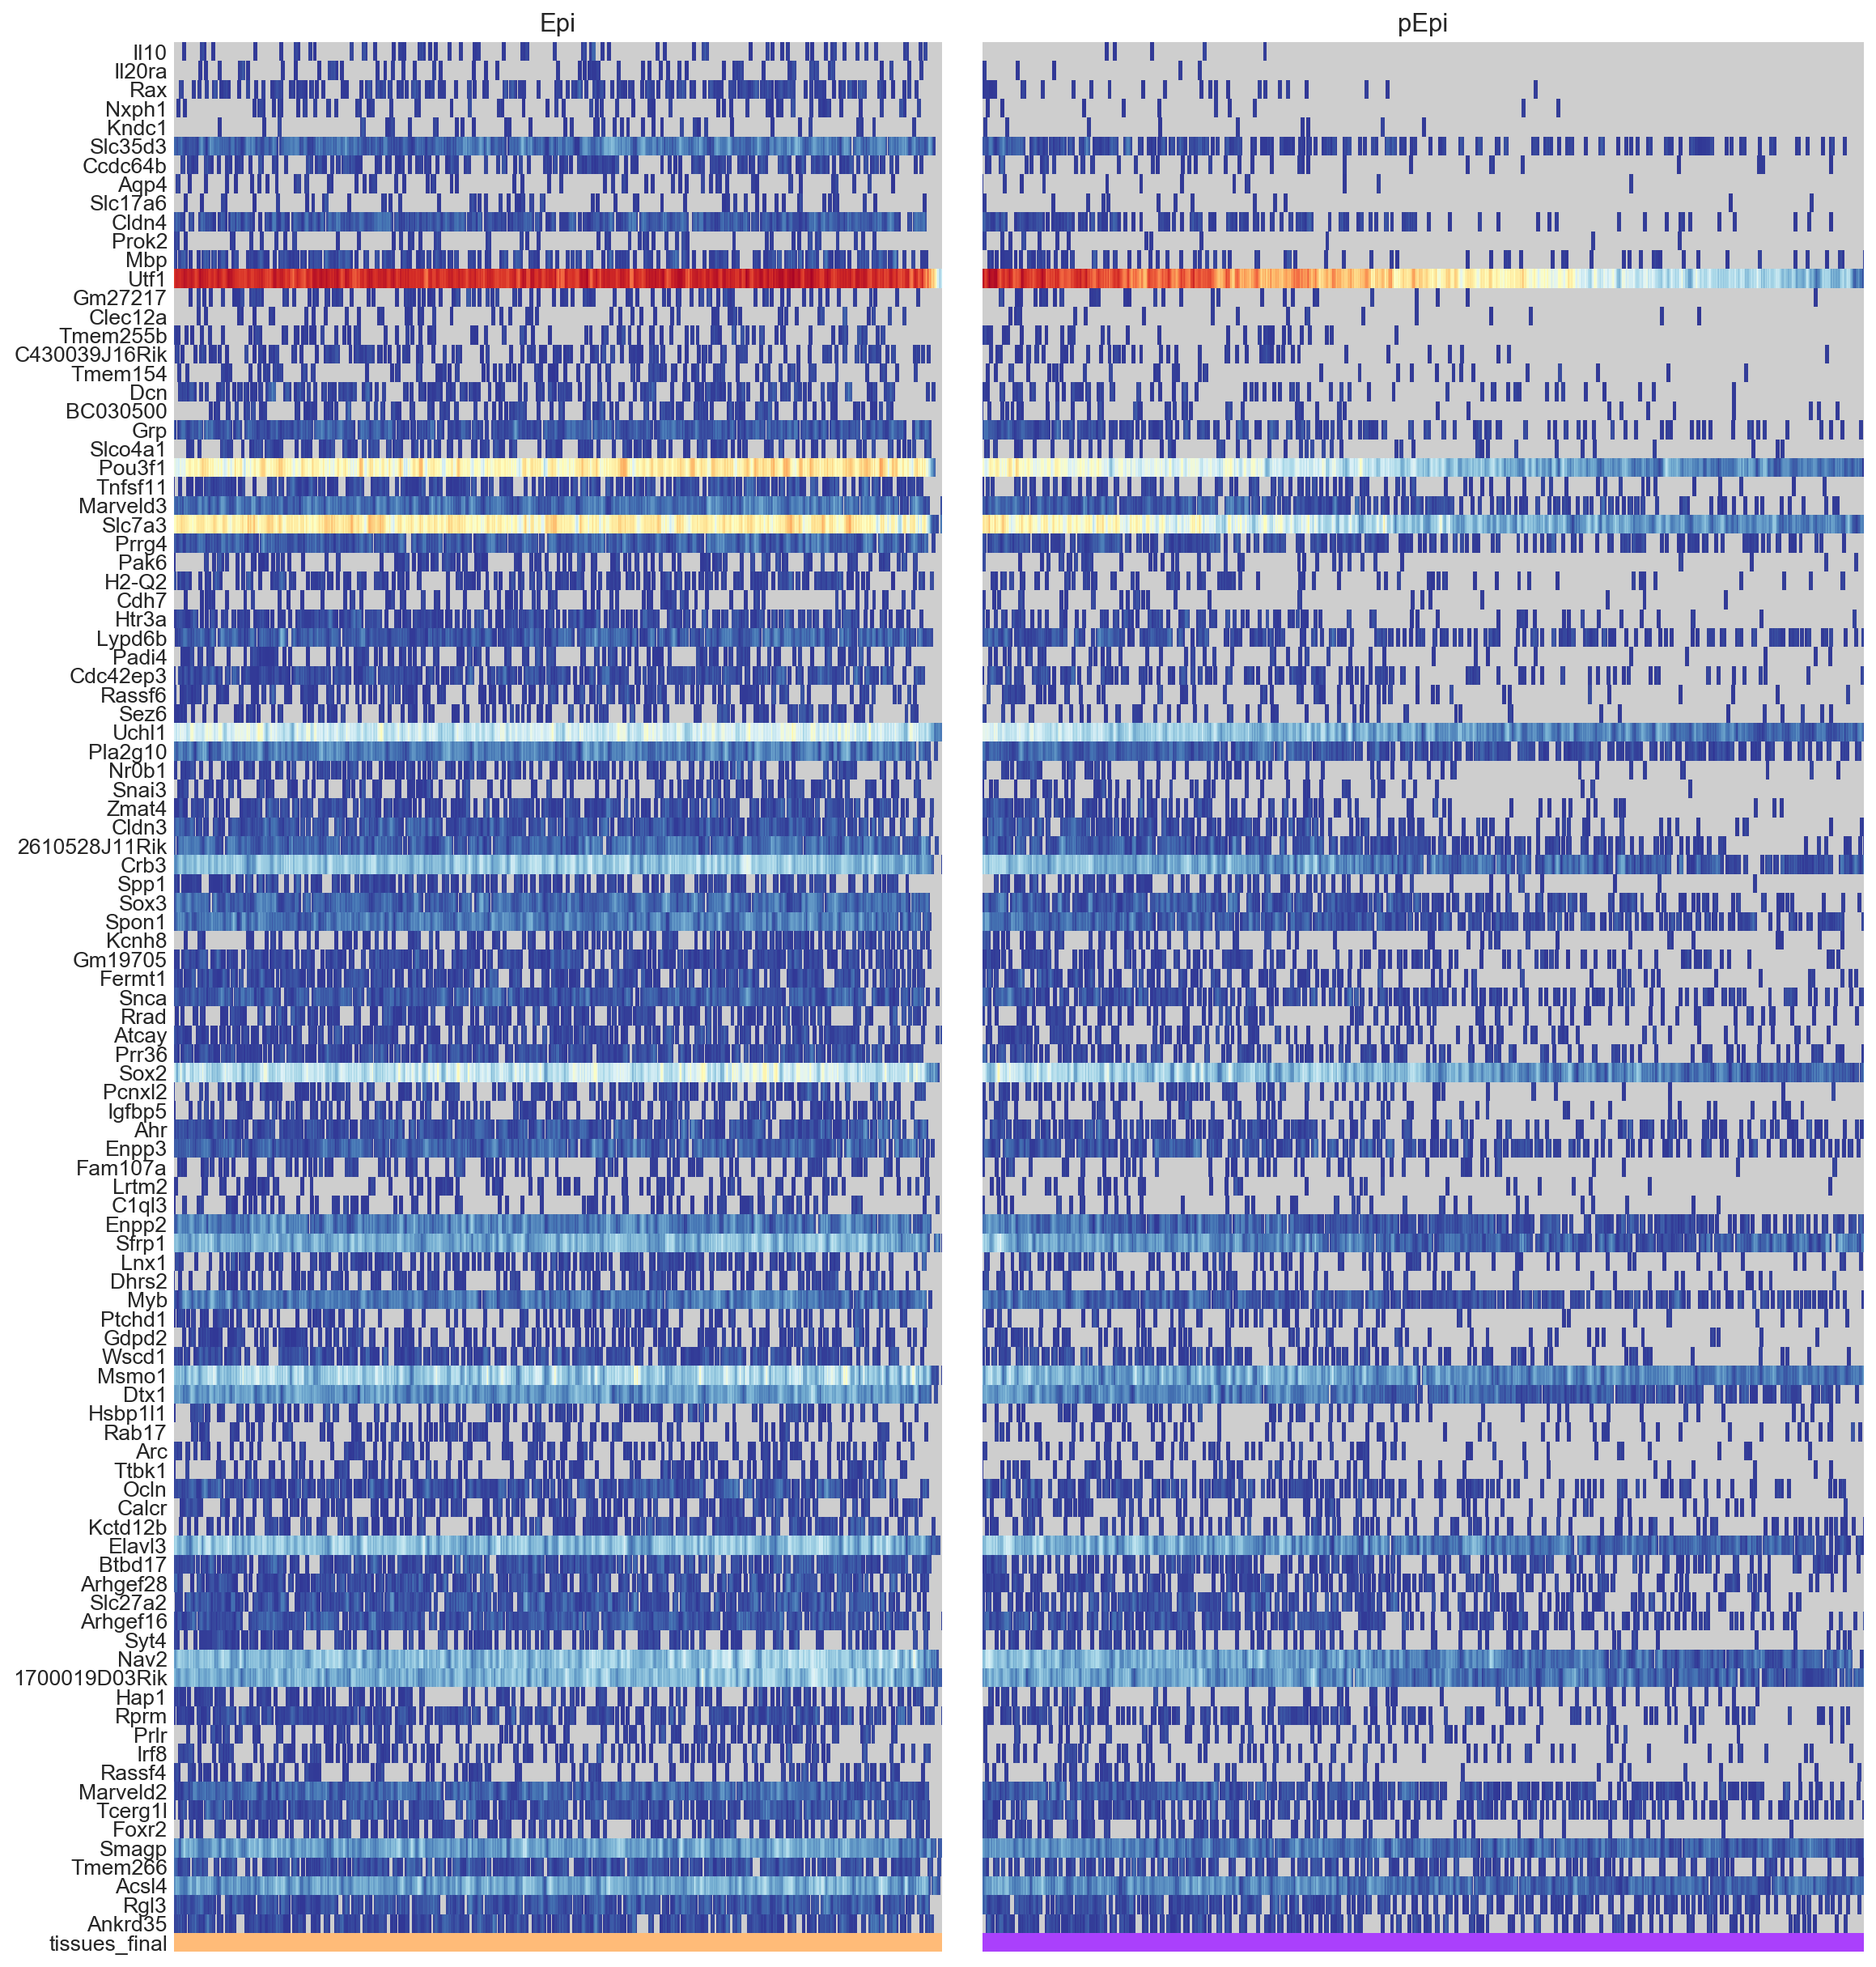

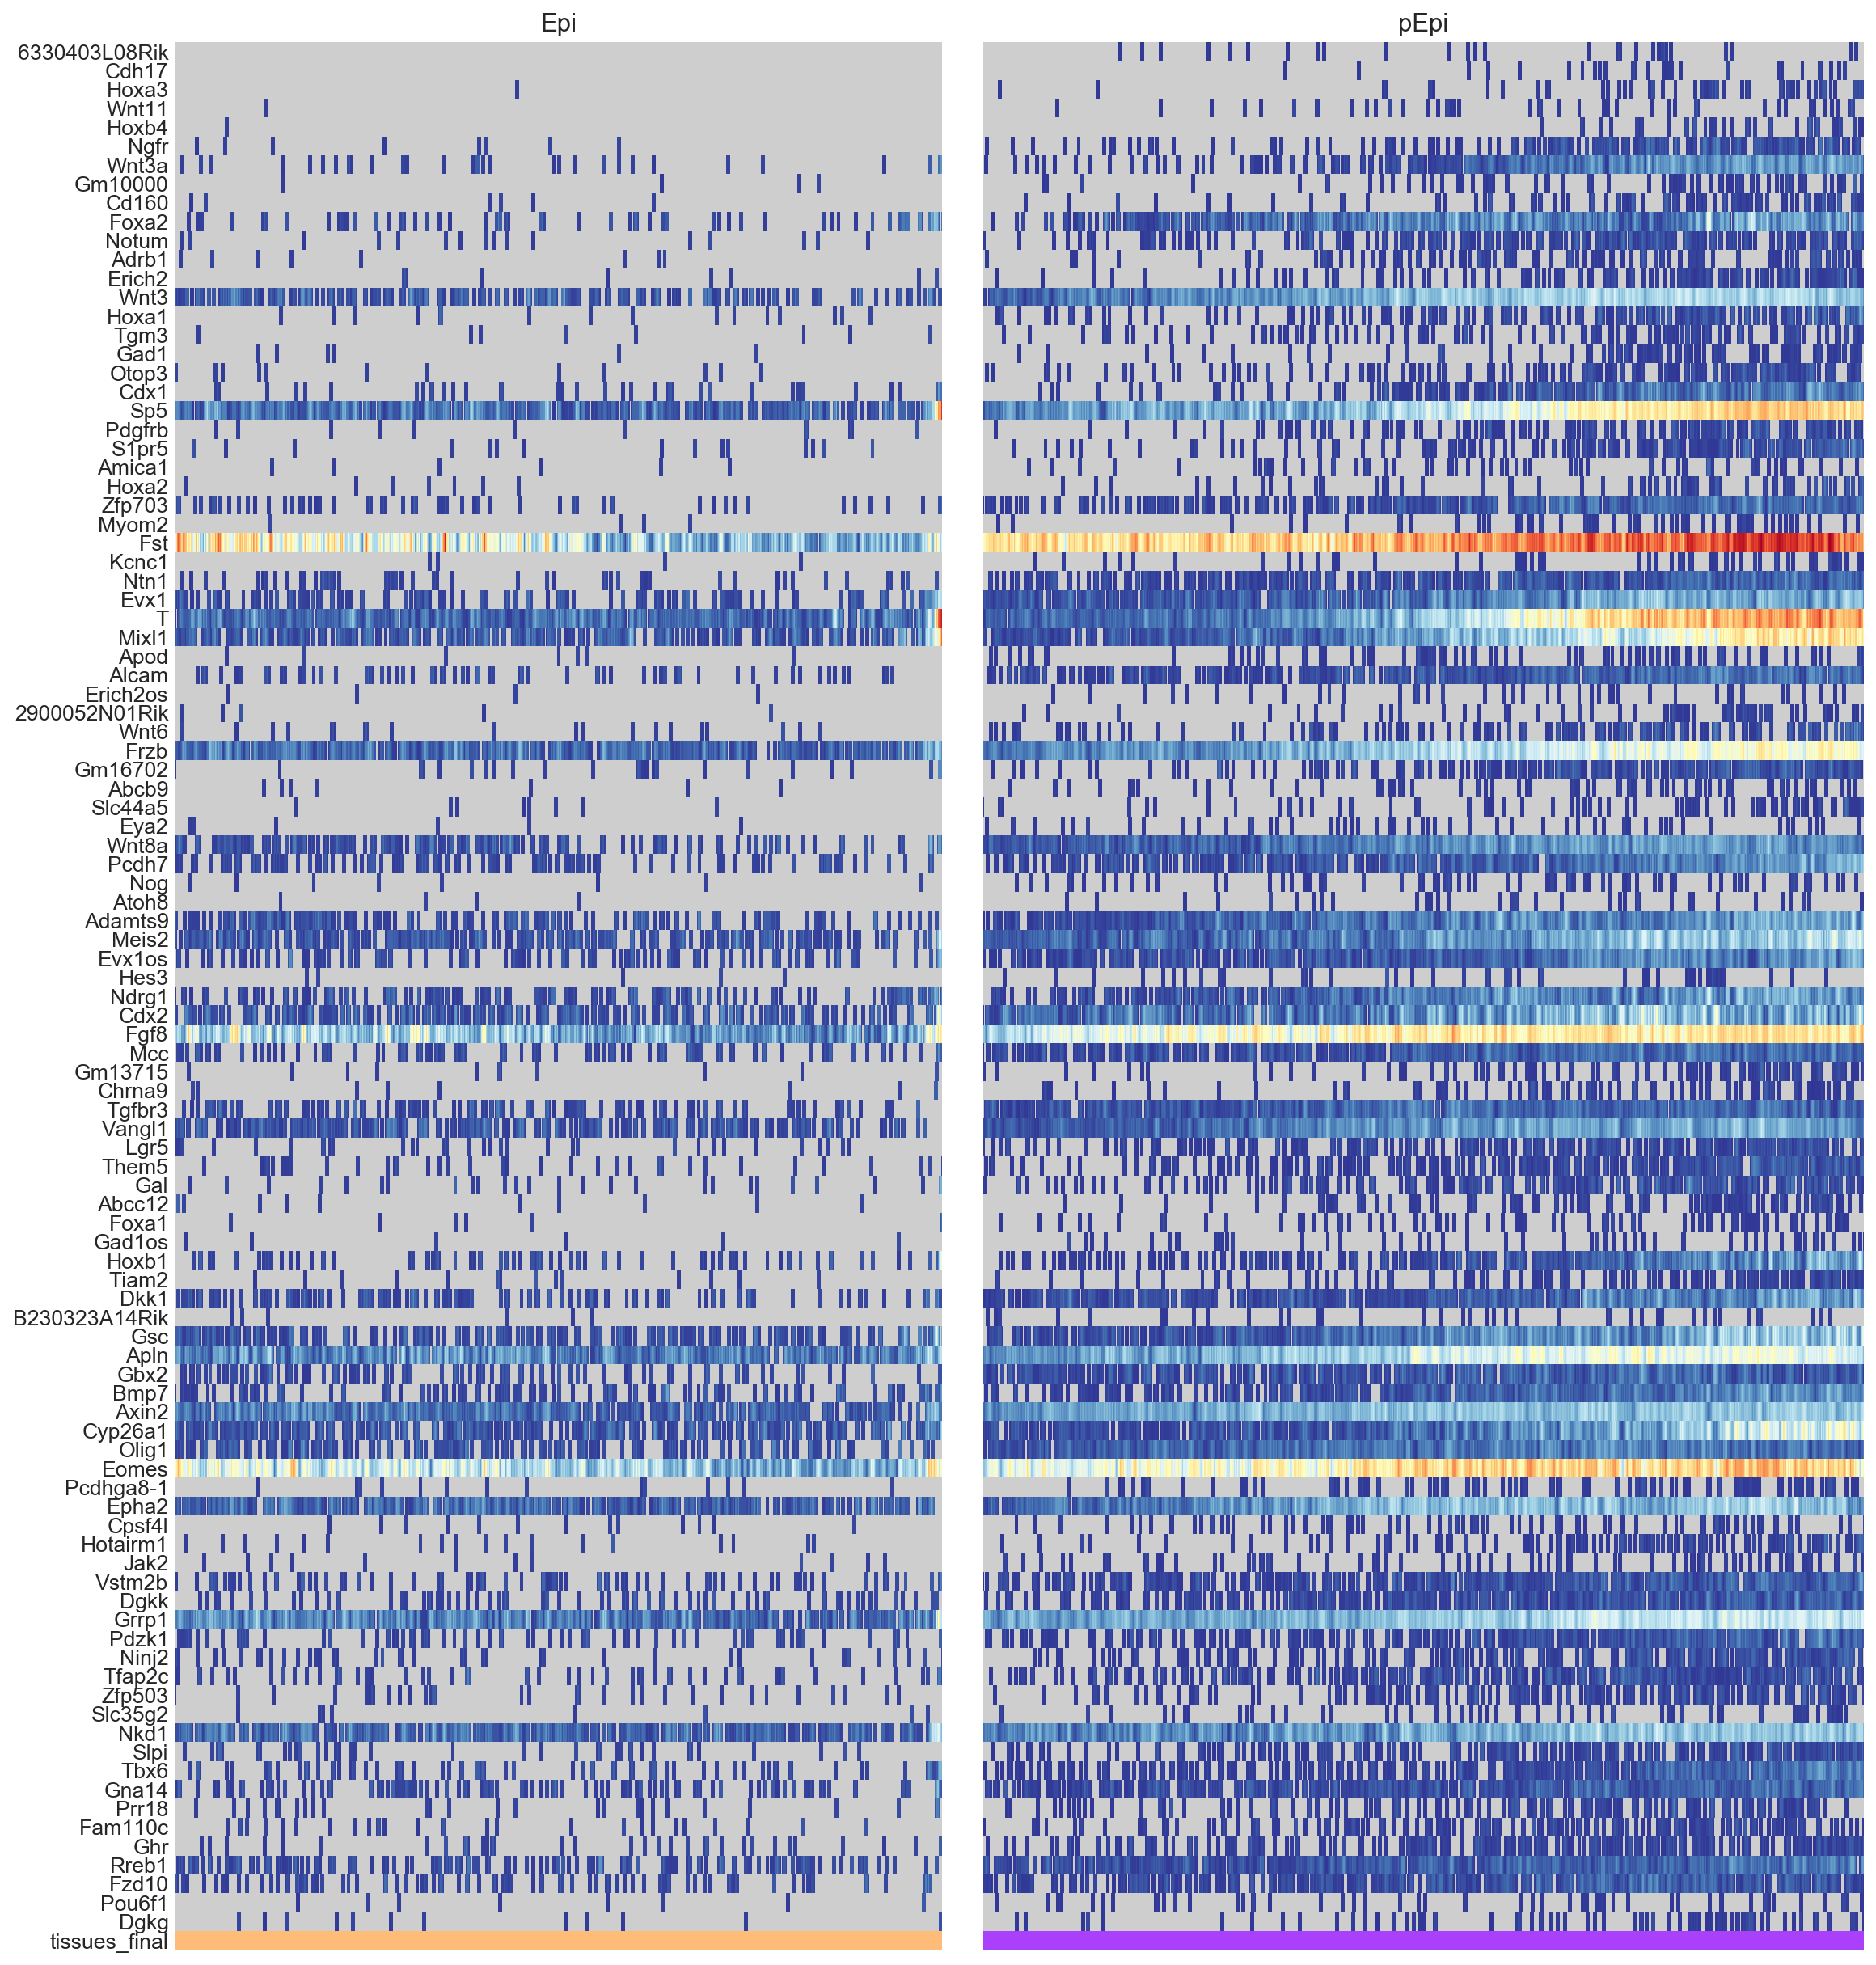

In [100]:

paths = [('Epi', ['epiblast']),
        ('pEpi',['posterior epiblast']),
        #('AM', ['axial mesoderm']),
    ]

path_ratios= pd.value_counts(adata.obs['tissues_final']).values
path_cat = pd.value_counts(adata.obs['tissues_final']).index
tmp=np.zeros(len(paths))
for ipath, (descr, path) in enumerate(paths):
    #print(path[1])
    idx = np.flatnonzero(np.in1d(path_cat, path))
    #print(idx)
    tmp[ipath] = path_ratios[idx]
    
tmp = tmp.astype('int')
path_ratios = tmp / tmp.sum() *len(path_ratios)

_, axs = pl.subplots(ncols=len(tmp), figsize=(15, 20), 
                     gridspec_kw={'wspace': 0.05, 'left': 0.11,'width_ratios':path_ratios})
pl.subplots_adjust(left=0.05, right=0.98, top=0.88)
for ipath, (descr, path) in enumerate(paths):
    sc.pl.paga_path(adata, left_margin=0.3, ytick_fontsize=12, color_map=mymap,
                   nodes=path, ax=axs[ipath],
                   keys=np.concatenate([low_epi_genes]),
                   annotations=[],
                   color_maps_annotations={'FVF' : 'Greys'},
                   show_yticks=True if ipath==0 else False,
                   show_node_names = False,
                   show_colorbar=True if ipath==3 else False,                        
                   n_avg=10,
                   normalize_to_zero_one = False,
                   title='{}'.format(descr),
                   show=False)
pl.savefig('./figures/' + today + '_heatmap_post_epi_vs_epi_low.pdf', dpi=150)
pl.show()

_, axs = pl.subplots(ncols=len(tmp), figsize=(15, 20), 
                     gridspec_kw={'wspace': 0.05, 'left': 0.11,'width_ratios':path_ratios})
pl.subplots_adjust(left=0.05, right=0.98, top=0.88)
for ipath, (descr, path) in enumerate(paths):
    sc.pl.paga_path(adata, left_margin=0.3, ytick_fontsize=12, color_map=mymap,
                   nodes=path, ax=axs[ipath],
                   keys=np.concatenate([high_epi_genes]),
                   annotations=[],
                   color_maps_annotations={'FVF' : 'Greys'},
                   show_yticks=True if ipath==0 else False,
                   show_node_names = False,
                   show_colorbar=True if ipath==3 else False,                        
                   n_avg=10,
                   normalize_to_zero_one = False,
                   title='{}'.format(descr),
                   show=False)
pl.savefig('./figures/' + today + '_heatmap_post_epi_vs_epi_high.pdf', dpi=150)
pl.show()

# Compare cells with different Foxa2 levels and FVF status

Merge `obs` metadata for FVF sorting and Foxa2 mRNA expression.

In [51]:
adata.obs['FVF_Foxa2'] = [adata.obs['FVF'][idx] + ' ' + adata.obs['Foxa2_levels'][idx]  for idx in range(adata.n_obs)]

In [52]:
adata.obs['FVF_Foxa2'].value_counts()

FVF_neg Foxa2 neg     4128
FVF_low Foxa2 neg     2804
FVF_high Foxa2 pos    1961
FVF_high Foxa2 neg     482
FVF_low Foxa2 pos      374
FVF_neg Foxa2 pos       45
Name: FVF_Foxa2, dtype: int64

Further, we merge all FVF_neg populations as we observe only few `FVF_neg Foxa2 pos` cells.

In [53]:
adata.obs['FVF_Foxa2'] = adata.obs['FVF_Foxa2'].astype('category')
adata.obs['FVF_Foxa2'] = adata.obs['FVF_Foxa2'].cat.add_categories(['FVF neg' ])
adata.obs['FVF_Foxa2'][np.in1d(adata.obs['FVF'],  ['FVF_neg'])] = 'FVF neg'
adata.obs['FVF_Foxa2'] = adata.obs['FVF_Foxa2'].cat.remove_unused_categories()

Rename the remaining populations and remove underscores.

In [54]:
rename_dict= {'FVF_low Foxa2 neg': 'FVF low - Foxa2 mRNA-',
              'FVF_high Foxa2 neg' : 'FVF high - Foxa2 mRNA-',
              'FVF_low Foxa2 pos': 'FVF low - Foxa2 mRNA+',
              'FVF_high Foxa2 pos' : 'FVF high - Foxa2 mRNA+',
             }

In [55]:
adata.obs['FVF_Foxa2'] = adata.obs['FVF_Foxa2'].cat.rename_categories(rename_dict)

In [56]:
adata.obs['FVF_Foxa2'] = adata.obs['FVF_Foxa2'].cat.reorder_categories([
      'FVF high - Foxa2 mRNA+','FVF high - Foxa2 mRNA-', 
        'FVF low - Foxa2 mRNA+' , 'FVF low - Foxa2 mRNA-',
       'FVF neg' 
    ])

In [57]:
adata.obs['FVF_Foxa2'].cat.categories

Index(['FVF high - Foxa2 mRNA+', 'FVF high - Foxa2 mRNA-',
       'FVF low - Foxa2 mRNA+', 'FVF low - Foxa2 mRNA-', 'FVF neg'],
      dtype='object')

In [58]:
adata.uns['FVF_Foxa2_colors'] = []
adata.uns['FVF_Foxa2_colors'].append('#32cd32') #FVF high - Foxa2 mRNA+
adata.uns['FVF_Foxa2_colors'].append('#caff70') #FVF high - Foxa2 mRNA-
adata.uns['FVF_Foxa2_colors'].append('#b22222') #FVF low - Foxa2 mRNA+
adata.uns['FVF_Foxa2_colors'].append('#ffbf0e') #FVF low - Foxa2 mRNA-
adata.uns['FVF_Foxa2_colors'].append('#bcd2ee') #FVF neg 

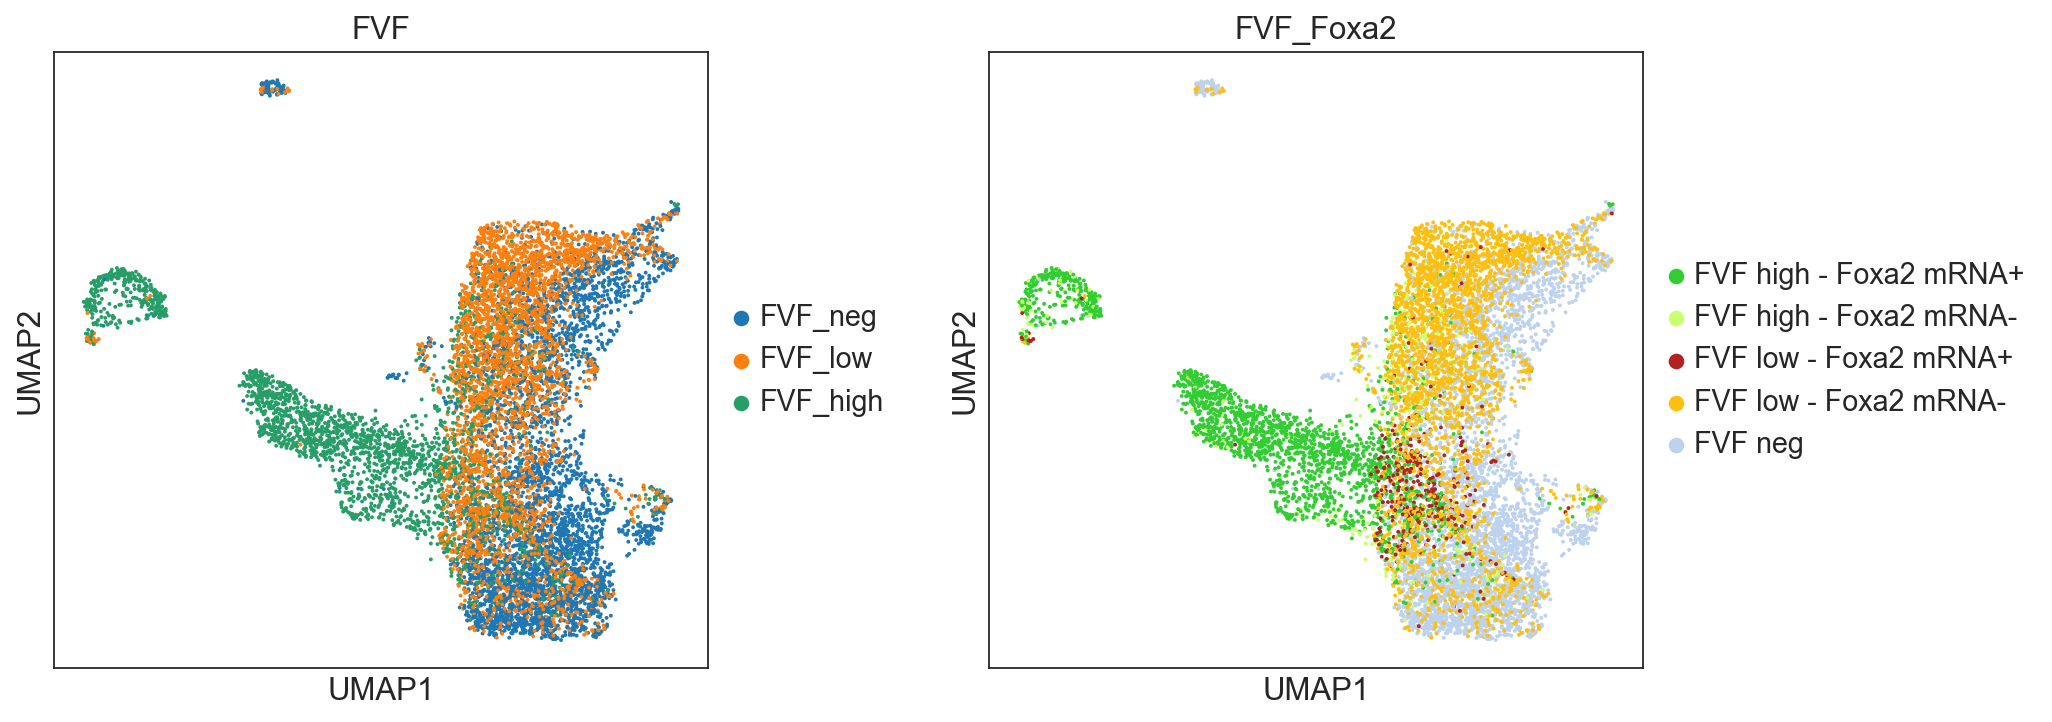

In [126]:
rcParams['figure.figsize']=(5,5)
sc.pl.umap(adata, color=[ 'FVF', 'FVF_Foxa2'], wspace=0.3, ncols=2,
           save=today + 'Foxa2_levels.pdf'
          )


In [11]:
adata_tmp = adata[adata.obs['tissues_final']=='posterior epiblast'].copy()

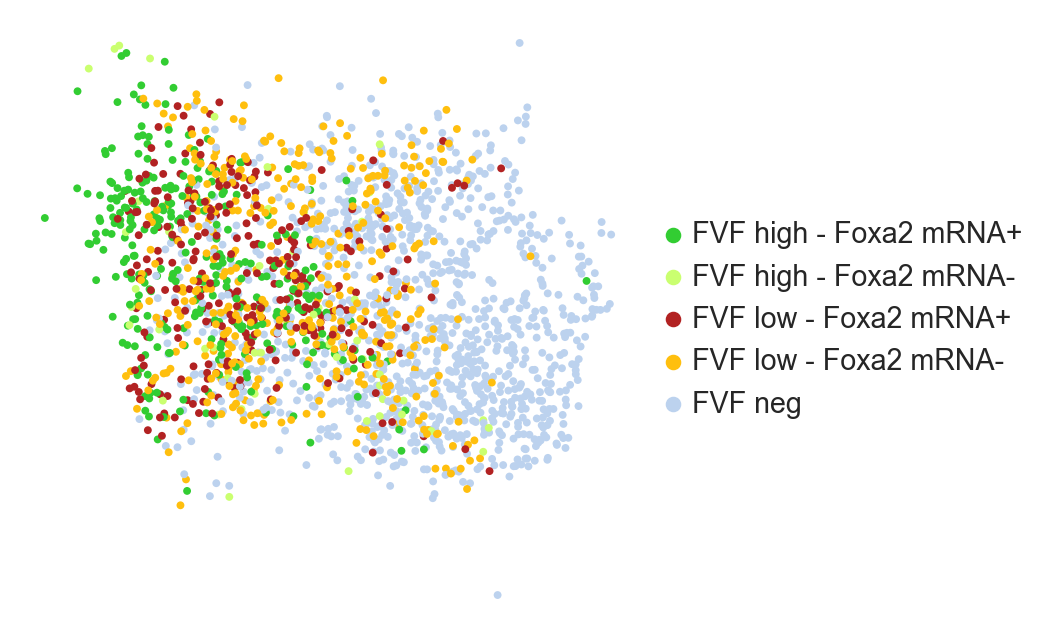

In [14]:
rcParams['figure.figsize']=(5,5)
sc.pl.umap(adata_tmp, color=['FVF_Foxa2'], frameon=False, size=50, title='',
           save=today + 'pEpi_FVF_Foxa2_levels.pdf')

## save to file

In [59]:
adata.write(data_dir + 'data_annotated_dec20.h5ad')